<a href="https://colab.research.google.com/github/Mohamed-Diagne/Portfolio-Risk-and-VaR-Modeling-From-Markowitz-Optimization-to-Monte-Carlo-Simulations/blob/main/Portfolio_Risk_and_VaR_Modeling_From_Markowitz_Optimization_to_Monte_Carlo_Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Portfolio Risk Management and VaR Modeling: From Markowitz Optimization to Monte Carlo Simulations**

## **2. Data Collection and Preprocessing**

In [ ]:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
import seaborn as sns

### **2.1. Download and Prepare CAC 40 Data**

In [ ]:
# Define start and end dates
start_date = "2010-01-01"
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

# Download CAC 40 data (^FCHI from Yahoo Finance)
cac40 = yf.download("^FCHI", start=start_date, end=end_date)

# Reset index and keep only Date and Close price
cac40 = cac40.reset_index()[["Date", "Close"]]

# Rename columns
cac40.columns = ["Date", "CAC40"]

# Convert Close price to log price
cac40["LCAC40"] = np.log(cac40["CAC40"])

# Compute first difference of log prices (Log Returns)
cac40["DLCAC40"] = cac40["LCAC40"].diff()

# Remove NaN values (first difference creates a missing value at the start)
cac40.dropna(inplace=True)

display(cac40.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Date,CAC40,LCAC40,DLCAC40
1,2010-01-05,4012.909912,8.297272,-0.000264
2,2010-01-06,4017.669922,8.298457,0.001185
3,2010-01-07,4024.800049,8.300231,0.001773
4,2010-01-08,4045.139893,8.305271,0.005041
5,2010-01-11,4043.090088,8.304765,-0.000507


### **2.2. Compute and Plot Cumulative Return**



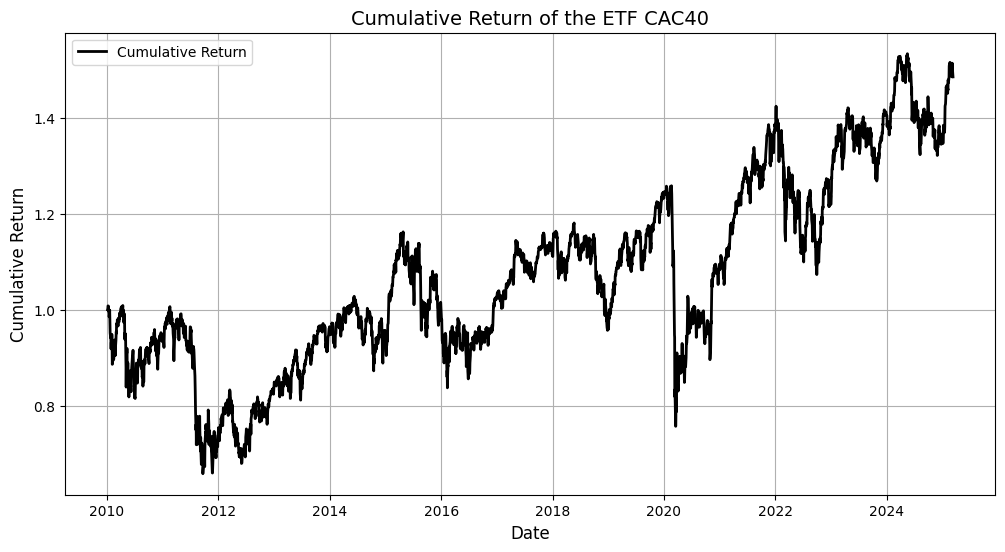

In [ ]:
# Compute cumulative return
cac40['Cumulative_Return'] = (1 + cac40['DLCAC40']).cumprod()

# Plot cumulative return
plt.figure(figsize=(12, 6))
plt.plot(cac40['Date'], cac40['Cumulative_Return'], label='Cumulative Return', color='black', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.title('Cumulative Return of the ETF CAC40', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### **2.3. Calculate Financial Metrics**

In [ ]:
# Total Return Calculation
total_return = (cac40['Cumulative_Return'].iloc[-1] - 1) * 100

# Compute number of years in dataset
nb_years = (cac40['Date'].iloc[-1] - cac40['Date'].iloc[0]).days / 365.25

# Annualized Return
annualized_return = ((1 + total_return / 100) ** (1 / nb_years) - 1) * 100

# Annualized Volatility (Standard deviation of daily returns annualized)
annualized_volatility = cac40['DLCAC40'].std() * np.sqrt(252) * 100

# Sharpe Ratio (assuming risk-free rate = 0)
sharpe_ratio = annualized_return / annualized_volatility

In [ ]:
print("=" * 50)
print(f"Performance Metrics for CAC 40 ETF ({start_date} - {end_date})")
print("=" * 50)
print(f"Total Return: {total_return:.2f}%")
print(f"Annualized Return: {annualized_return:.2f}%")
print(f"Annualized Volatility: {annualized_volatility:.2f}%")
print(f"Sharpe Ratio (Risk-Free Rate = 0%): {sharpe_ratio:.2f}")
print("=" * 50)


Performance Metrics for CAC 40 ETF (2010-01-01 - 2025-03-11)
Total Return: 48.52%
Annualized Return: 2.64%
Annualized Volatility: 19.69%
Sharpe Ratio (Risk-Free Rate = 0%): 0.13


### **2.4. Download & Clean Data for Diversified Portfolio**

In [ ]:
# Define updated asset list (40 assets)
tickers = [
    "MC.PA", "OR.PA", "TTE.PA", "BNP.PA", "AIR.PA", "RI.PA", "SGO.PA", "CS.PA",  # France (8)
    "AAPL", "MSFT", "F", "NVDA", "AMZN", "GOOG", "IBM", "JPM", "KO", "JNJ",  # USA (10)
    "SAP.DE", "SIE.DE", "ULVR.L", "NESN.SW",  # Europe ex-France (4)
    "NTES", "TSM", "INFY", "RELIANCE.NS", "VALE", "PBR", "9984.T", "7203.T",  # Emerging markets & Asia (8)
    "GLD", "SLV", "RIO", "XLB",  # Commodities - Metals (4)
    "USO", "XLE", "NG",  # Commodities - Energy (3)
    "DBA", "MOO", "XLP"  # Commodities - Agriculture (3)
]

# Download adjusted closing prices for all assets
data = yf.download(tickers, start=start_date, end=end_date, interval="1d")["Close"]

# Ensure 'Date' column is properly formatted
data = data.reset_index()
data["Date"] = pd.to_datetime(data["Date"])

# Handle missing values (Forward Fill method)
data.fillna(method='ffill', inplace=True)

# Compute logarithmic returns
log_returns = data.copy()
for col in log_returns.columns[1:]:  # Ignore the Date column
    log_returns[col] = np.log(log_returns[col] / log_returns[col].shift(1))

# Drop NaN values generated by differencing
log_returns.dropna(inplace=True)

# Convert 'Date' to index for time series analysis
log_returns.set_index("Date", inplace=True)

# Display data information
display(data.head())

[*********************100%***********************]  40 of 40 completed
<ipython-input-6-9949e47ea969>:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


Ticker,Date,7203.T,9984.T,AAPL,AIR.PA,AMZN,BNP.PA,CS.PA,DBA,F,...,SIE.DE,SLV,TSM,TTE.PA,ULVR.L,USO,VALE,XLB,XLE,XLP
0,2010-01-04,528.769043,978.693787,6.440332,11.342544,6.6950,26.057642,7.704947,23.769955,5.499459,...,32.746872,17.230000,7.353935,18.990189,1985.606934,322.160004,13.205762,24.620661,35.923317,17.821743
1,2010-01-05,517.214966,980.492920,6.451466,11.306059,6.7345,26.007568,7.833362,23.921360,5.863236,...,32.766880,17.510000,7.322185,19.013004,1942.830811,323.279999,13.345457,24.700272,36.216522,17.828426
2,2010-01-06,529.448669,984.090759,6.348845,11.407407,6.6125,26.048534,7.913622,24.054945,6.082573,...,32.886925,17.860001,7.296782,19.025448,1944.820312,327.760010,13.559366,25.120020,36.650208,17.815058
3,2010-01-07,523.331726,987.689087,6.337108,11.520914,6.5000,26.503771,7.824189,23.867920,6.237713,...,33.277061,17.889999,7.055461,19.058626,1920.946045,325.760010,13.598660,24.924618,36.595261,17.815058
4,2010-01-08,538.284119,980.492920,6.379241,11.634418,6.6760,27.131996,7.849415,23.939169,6.253762,...,33.487137,18.150000,7.049111,19.079350,1925.919434,327.440002,13.742722,25.272001,36.833466,17.754908


## **3. Portfolio Optimization**

### **3.1. Markowitz Portfolio Optimization Function**

 Optimizes portfolio allocation using Markowitz framework to minimize volatility.

In [ ]:
# Use the precomputed log_returns dataset
returns = log_returns.copy()

# Parameters for rolling window and rebalancing
window_size = 200  # Rolling window size in days
rebalance_period = 40  # Rebalancing frequency in days

In [ ]:
def optimize_markowitz_sharpe(returns_data, risk_free_rate=0.02, max_weight=0.4):
    """
    Optimizes portfolio weights to maximize the Sharpe ratio.

    :param returns_data: DataFrame of asset returns (past `window_size` days)
    :param risk_free_rate: Risk-free rate used in Sharpe ratio calculation
    :param max_weight: Maximum weight constraint for any single asset
    :return: Optimized portfolio weights as a NumPy array
    """
    mean_returns = returns_data.mean()
    cov_matrix = returns_data.cov()
    n_assets = len(returns_data.columns)

    # Function to compute the negative Sharpe ratio (we minimize this)
    def neg_sharpe_ratio(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return - (portfolio_return - risk_free_rate) / portfolio_volatility  # Negative for minimization

    # Constraints: Sum of weights must be 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Bounds: No short-selling, max weight per asset
    bounds = tuple((0, max_weight) for _ in range(n_assets))

    # Initial guess: Equal allocation
    initial_guess = np.array([1 / n_assets] * n_assets)

    # Perform optimization
    result = minimize(neg_sharpe_ratio, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x if result.success else initial_guess  # Return initial guess if optimization fails


# Initialize storage for portfolio weights and performance
weights_history = pd.DataFrame(index=returns.index, columns=returns.columns)
portfolio_performance = pd.DataFrame(index=returns.index, columns=['Return'])

# Rolling window parameters
current_weights = None
last_rebalance_idx = window_size

# Iterate with rolling window
for i in range(window_size, len(returns)):
    current_date = returns.index[i]

    # Rebalance every `rebalance_period` days or on first iteration
    if current_weights is None or i >= last_rebalance_idx + rebalance_period:
        window_data = returns.iloc[i - window_size:i]
        current_weights = optimize_markowitz_sharpe(window_data)  # ✅ Use Sharpe ratio optimization
        last_rebalance_idx = i

    # Store weights and compute portfolio return
    weights_history.loc[current_date] = current_weights
    portfolio_performance.loc[current_date, 'Return'] = np.sum(returns.iloc[i] * current_weights)

# Compute cumulative returns
portfolio_performance['Cumulative_Return'] = (1 + portfolio_performance['Return']).cumprod()

# Drop NaN values
weights_history.dropna(inplace=True)
portfolio_performance.dropna(inplace=True)

# Display final results
display(portfolio_performance.head())


,Return,Cumulative_Return
Date,,
2010-10-12,-0.011026,0.988974
2010-10-13,0.031677,1.020302
2010-10-14,0.004343,1.024733
2010-10-15,0.00124,1.026004
2010-10-18,0.000674,1.026695


Visualization

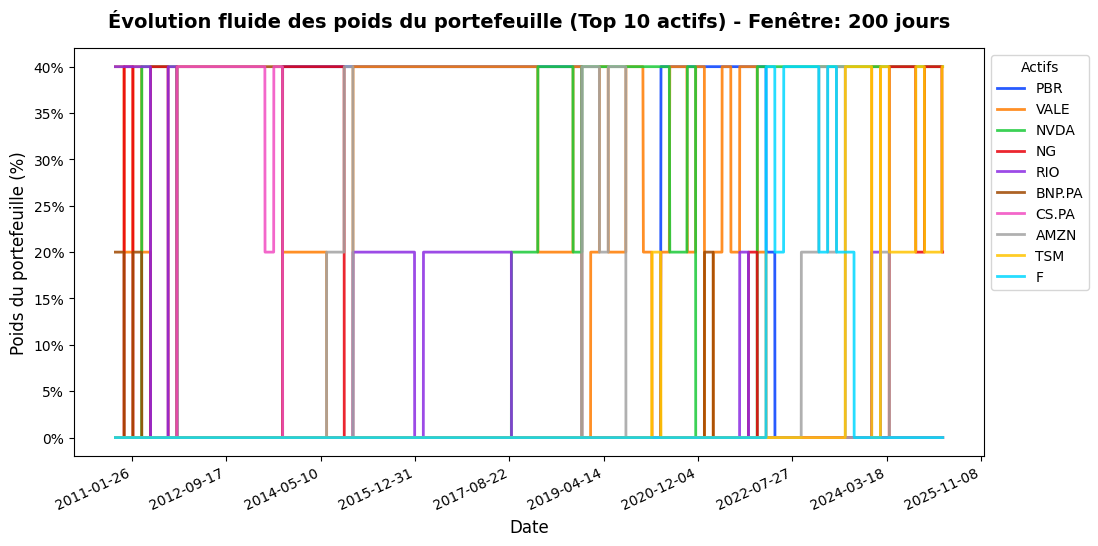

In [ ]:
#  Convert to numeric if needed
weights_history = weights_history.apply(pd.to_numeric, errors="coerce")

# Select top 10 assets by average weight
top_assets = weights_history.mean().nlargest(10).index
filtered_weights = weights_history[top_assets]

# Create a smooth line plot with interpolation
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)

# Color palette with smooth lines
color_palette = sns.color_palette("bright", n_colors=len(top_assets))

for i, asset in enumerate(top_assets):
    ax.plot(filtered_weights.index,
            filtered_weights[asset].interpolate(),  # 🔹 Lissage des courbes
            label=asset,
            color=color_palette[i],
            linewidth=2,
            alpha=0.85)

# Titles and labels
ax.set_title(f"Évolution fluide des poids du portefeuille (Top 10 actifs) - Fenêtre: {window_size} jours",
             fontsize=14, fontweight="bold", pad=15)
ax.set_ylabel("Poids du portefeuille (%)", fontsize=12)
ax.set_xlabel("Date", fontsize=12)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

#  Improve x-axis readability
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=25, ha="right")

#  Move and optimize legend
ax.legend(title="Actifs", fontsize=10, loc="upper left", bbox_to_anchor=(1, 1))

#  Adjust layout
plt.subplots_adjust(left=0.1, right=0.75, top=0.88, bottom=0.2)

plt.show()


In [ ]:
# Performance Statistics
performance_stats = {
    'Total Return': portfolio_performance['Cumulative_Return'].iloc[-1] - 1,
    'Annualized Return': portfolio_performance['Return'].mean() * 252,
    'Annualized Volatility': portfolio_performance['Return'].std() * np.sqrt(252),
    'Sharpe Ratio': (portfolio_performance['Return'].mean() / portfolio_performance['Return'].std()) * np.sqrt(252)
}

# Display performance statistics
print("\nPerformance Statistics:")
for stat, value in performance_stats.items():
    print(f"{stat}: {value:.4f}")



Performance Statistics:
Total Return: 2.0883
Annualized Return: 0.1491
Annualized Volatility: 0.3833
Sharpe Ratio: 0.3890


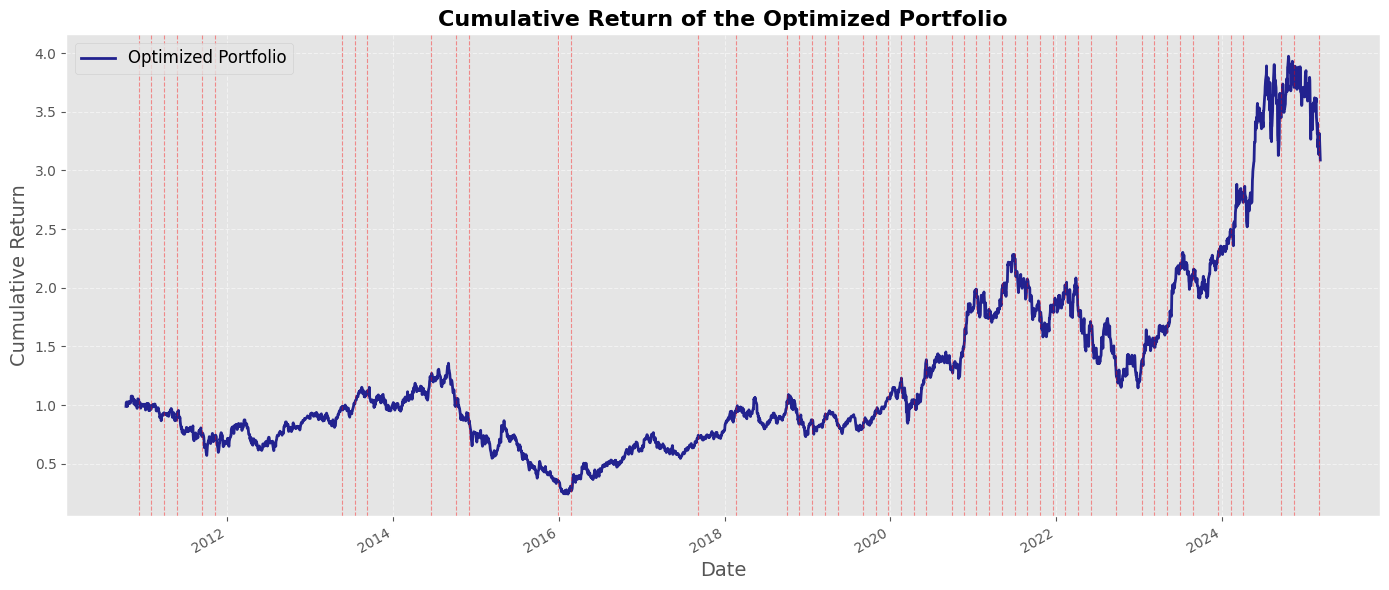

In [ ]:
# Définir le style et la figure
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)

# Tracer le rendement cumulé du portefeuille optimisé
portfolio_performance["Cumulative_Return"].plot(ax=ax, color="navy", linewidth=2, alpha=0.85, label="Optimized Portfolio")

# Ajouter des lignes verticales aux dates de rééquilibrage
rebalancing_dates = weights_history.iloc[1:].diff().abs().sum(axis=1)
rebalancing_dates = rebalancing_dates[rebalancing_dates > 0.001].index
for date in rebalancing_dates:
    ax.axvline(date, color="red", linestyle="--", alpha=0.4, linewidth=0.8)

# Ajouter titre et labels
ax.set_title("Cumulative Return of the Optimized Portfolio", fontsize=16, fontweight="bold")
ax.set_ylabel("Cumulative Return", fontsize=14)
ax.set_xlabel("Date", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.5)

# Ajouter une légende
ax.legend(loc="upper left", fontsize=12, frameon=True)

# Ajustement de la mise en page
plt.tight_layout()
plt.show()


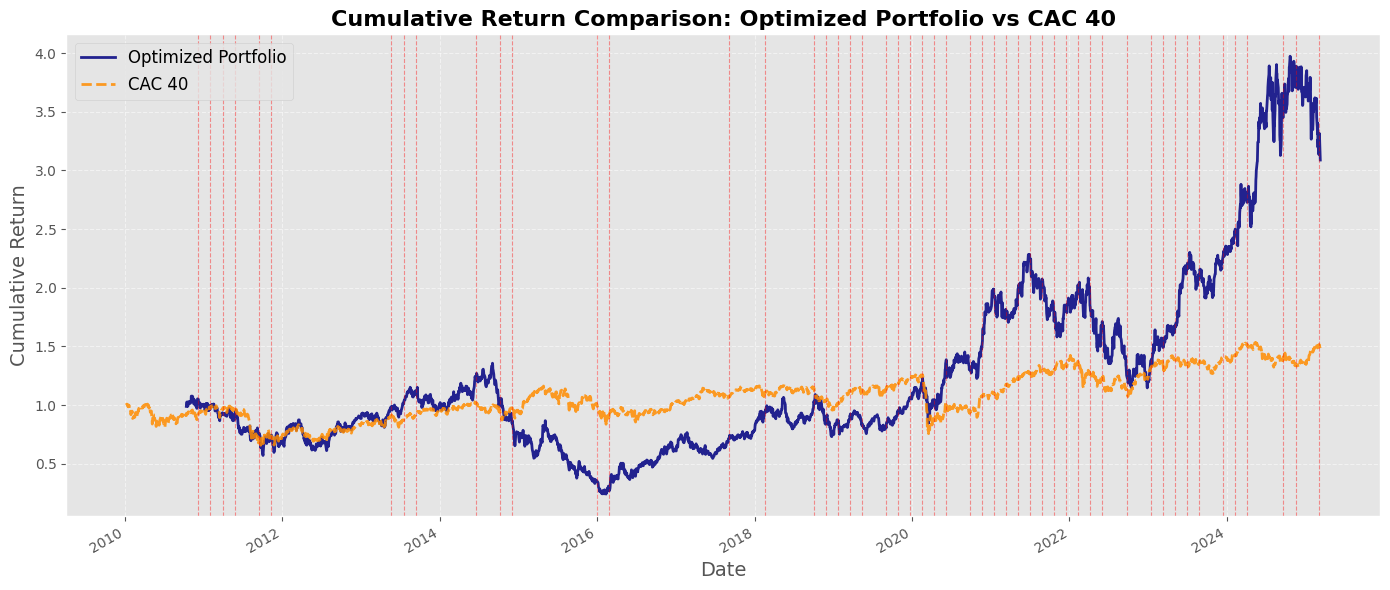

In [ ]:
# Définir le style et la figure
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)

# Tracer le rendement cumulé du portefeuille optimisé
portfolio_performance["Cumulative_Return"].plot(ax=ax, color="navy", linewidth=2, alpha=0.85, label="Optimized Portfolio")

# Vérifier si la colonne DLCAC40 existe bien
if "DLCAC40" in cac40.columns:
    # Calculer le rendement cumulé du CAC 40
    cac40["Cumulative_Return"] = (1 + cac40["DLCAC40"]).cumprod()

    # Tracer le rendement cumulé du CAC 40
    cac40.plot(x="Date", y="Cumulative_Return", ax=ax, color="darkorange", linewidth=2, alpha=0.85, linestyle="--", label="CAC 40")

# Ajouter des lignes verticales aux dates de rééquilibrage
rebalancing_dates = weights_history.iloc[1:].diff().abs().sum(axis=1)
rebalancing_dates = rebalancing_dates[rebalancing_dates > 0.001].index
for date in rebalancing_dates:
    ax.axvline(date, color="red", linestyle="--", alpha=0.4, linewidth=0.8)

# Ajouter titre et labels
ax.set_title("Cumulative Return Comparison: Optimized Portfolio vs CAC 40", fontsize=16, fontweight="bold")
ax.set_ylabel("Cumulative Return", fontsize=14)
ax.set_xlabel("Date", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.5)

# Ajouter une légende
ax.legend(loc="upper left", fontsize=12, frameon=True)

# Ajustement de la mise en page
plt.tight_layout()
plt.show()


# **4. VAR Calculations**

**Histogram and Distribution Fitting**

This section extracts the CAC 40 returns, plots the histogram, and overlays the normal and Student's t-distributions for visual comparison.

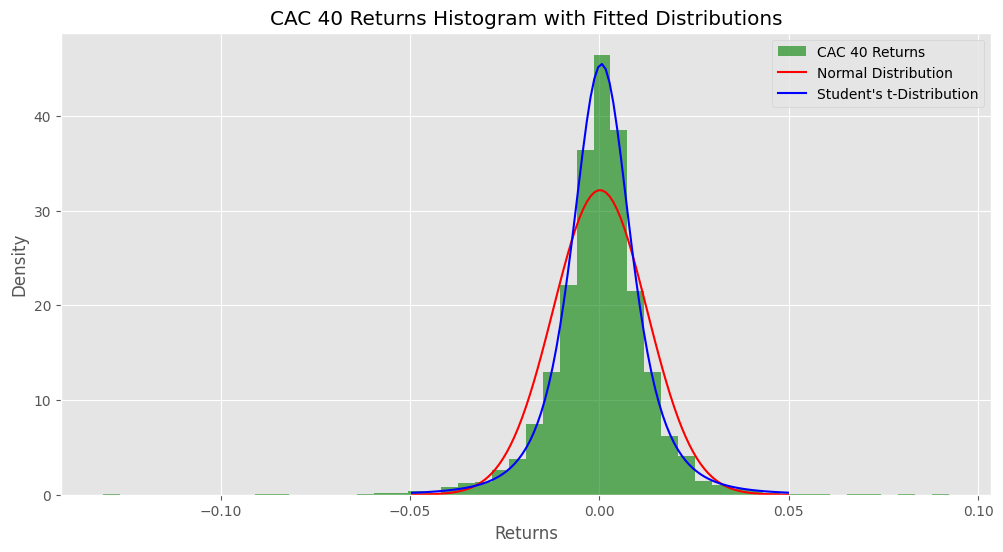

In [ ]:
# Extract CAC 40 returns
returns = cac40['DLCAC40'].dropna()

# Compute normal distribution parameters
mu, sigma = returns.mean(), returns.std()

# Compute Student's t-distribution parameters
df, loc, scale = stats.t.fit(returns)

# Create the histogram
plt.figure(figsize=(12, 6))
plt.hist(returns, bins=50, density=True, alpha=0.6, color='g', label='CAC 40 Returns')

# Generate x-values for the fitted distributions
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)

# Plot the normal distribution
plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', label='Normal Distribution')

# Plot the Student's t-distribution
plt.plot(x, stats.t.pdf(x, df, loc, scale), 'b-', label="Student's t-Distribution")

# Customize the plot
plt.title("CAC 40 Returns Histogram with Fitted Distributions")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


**Histogram and Distribution Fitting for the Portfolio**

In [ ]:
# Convert portfolio returns to numeric values and drop NaNs/infinite values
portfolio_returns = pd.to_numeric(portfolio_performance['Return'], errors='coerce').dropna()

# Check for infinite values
portfolio_returns = portfolio_returns[np.isfinite(portfolio_returns)]


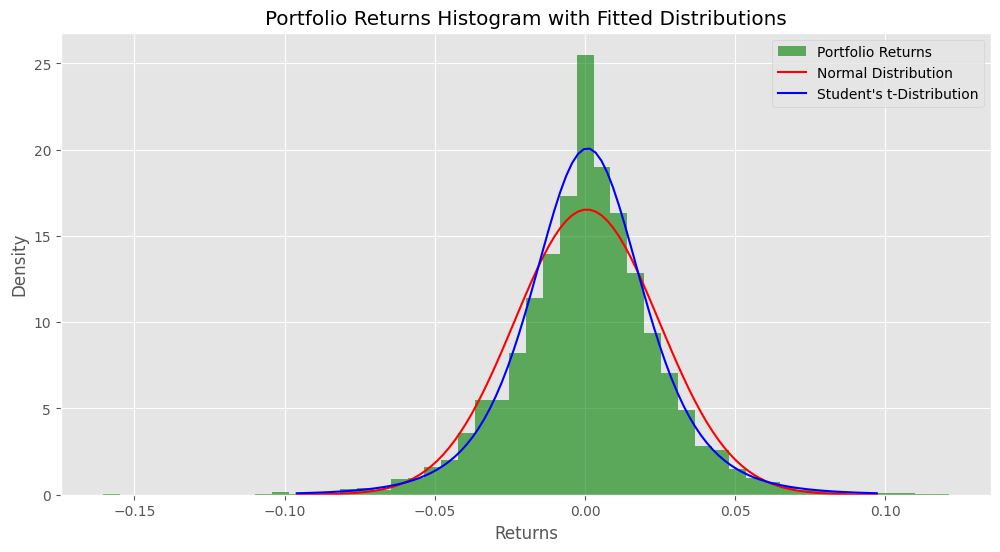

In [ ]:
# Ensure portfolio_returns is clean and numeric
portfolio_returns = pd.to_numeric(portfolio_performance['Return'], errors='coerce').dropna()
portfolio_returns = portfolio_returns[np.isfinite(portfolio_returns)]  # Remove infinite values

# Compute normal distribution parameters
mu, sigma = portfolio_returns.mean(), portfolio_returns.std()

# Compute Student's t-distribution parameters
df, loc, scale = stats.t.fit(portfolio_returns)  # This should now work

# Create histogram
plt.figure(figsize=(12, 6))
plt.hist(portfolio_returns, bins=50, density=True, alpha=0.6, color='g', label='Portfolio Returns')

# Generate x-values for the fitted distributions
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)

# Plot the normal distribution
plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', label='Normal Distribution')

# Plot the Student's t-distribution
plt.plot(x, stats.t.pdf(x, df, loc, scale), 'b-', label="Student's t-Distribution")

# Customize the plot
plt.title("Portfolio Returns Histogram with Fitted Distributions")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


**Statistical Tests & Rolling Window Analysis**

This section performs normality tests and analyzes whether CAC 40 returns follow a normal or Student's t-distribution over rolling windows.

In [ ]:
# Statistical tests
shapiro_test = stats.shapiro(returns)
ks_test_norm = stats.kstest(returns, 'norm', args=(mu, sigma))
ks_test_t = stats.kstest(returns, 't', args=(df, loc, scale))

# Print test results
print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f}")
print(f"Kolmogorov-Smirnov Test (Normal): Statistic={ks_test_norm.statistic:.4f}, p-value={ks_test_norm.pvalue:.4f}")
print(f"Kolmogorov-Smirnov Test (Student): Statistic={ks_test_t.statistic:.4f}, p-value={ks_test_t.pvalue:.4f}")

# Rolling window normality analysis (252-day window)
window_size = 252
normal_count, student_count = 0, 0

for i in range(window_size, len(returns)):
    window_returns = returns.iloc[i - window_size:i]

    # Shapiro-Wilk test on the rolling window
    if stats.shapiro(window_returns).pvalue > 0.05:
        normal_count += 1
    else:
        student_count += 1

# Display results
print(f"Periods following a Normal Distribution: {normal_count}")
print(f"Periods following a Student's t-Distribution: {student_count}")


Shapiro-Wilk Test: Statistic=0.9310, p-value=0.0000
Kolmogorov-Smirnov Test (Normal): Statistic=0.1995, p-value=0.0000
Kolmogorov-Smirnov Test (Student): Statistic=0.1735, p-value=0.0000
Periods following a Normal Distribution: 378
Periods following a Student's t-Distribution: 3252


**Statistical Tests & Rolling Window Analysis for Portfolio**

In [ ]:
# Statistical tests
shapiro_test = stats.shapiro(portfolio_returns)
ks_test_norm = stats.kstest(portfolio_returns, 'norm', args=(mu, sigma))
ks_test_t = stats.kstest(portfolio_returns, 't', args=(df, loc, scale))

# Print test results
print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f}")
print(f"Kolmogorov-Smirnov Test (Normal): Statistic={ks_test_norm.statistic:.4f}, p-value={ks_test_norm.pvalue:.4f}")
print(f"Kolmogorov-Smirnov Test (Student): Statistic={ks_test_t.statistic:.4f}, p-value={ks_test_t.pvalue:.4f}")


Shapiro-Wilk Test: Statistic=0.9796, p-value=0.0000
Kolmogorov-Smirnov Test (Normal): Statistic=0.0471, p-value=0.0000
Kolmogorov-Smirnov Test (Student): Statistic=0.0231, p-value=0.0360


## **4.1.1 Historical VAR**

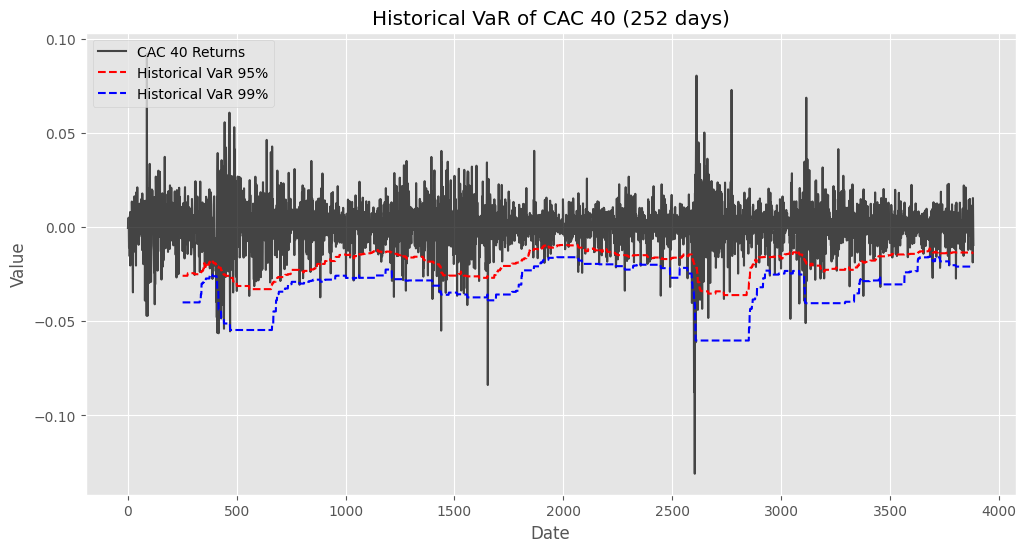

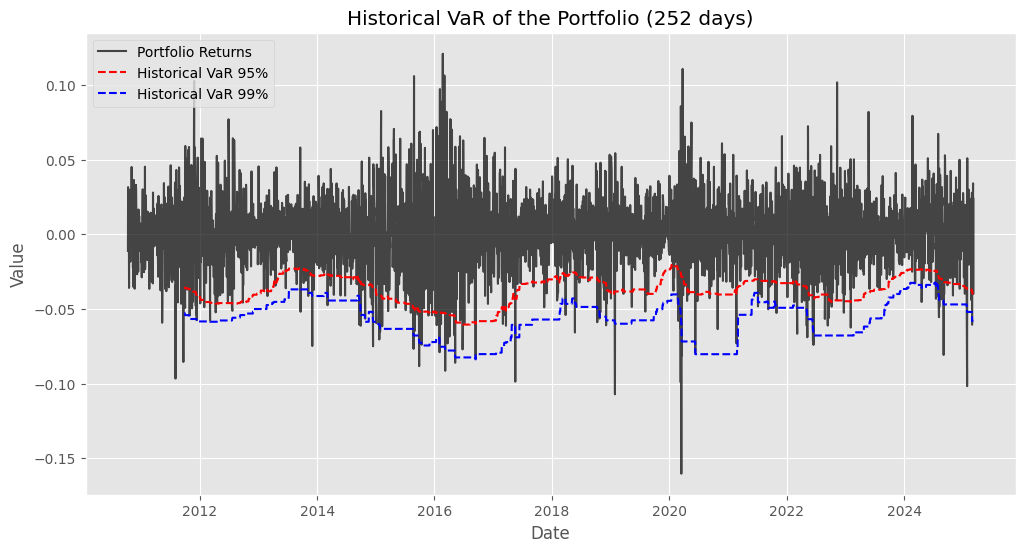

,Mean,Standard Deviation,Minimum,Maximum,Skewness,Kurtosis
CAC 40 VaR 95%,-0.019363,0.006891,-0.036055,-0.009286,-0.862281,-0.156877
Portfolio VaR 95%,-0.037248,0.009314,-0.060422,-0.020100,-0.527020,-0.290141
CAC 40 VaR 99%,-0.031572,0.012239,-0.060198,-0.015612,-0.995023,0.152799
Portfolio VaR 99%,-0.056860,0.013205,-0.083734,-0.032380,-0.316616,-0.748976


In [ ]:
# Ensure data is numeric and clean
cac40['DLCAC40'] = pd.to_numeric(cac40['DLCAC40'], errors='coerce').dropna()
portfolio_returns = pd.to_numeric(portfolio_performance['Return'], errors='coerce').dropna()

# Function to calculate Historical VaR
def calculate_historical_var(returns, window=252, confidence_levels=[0.95, 0.99]):
    """
    Computes Historical VaR by taking the empirical quantile over a rolling window.

    :param returns: Time series of asset returns
    :param window: Rolling window size (default: 252 days)
    :param confidence_levels: Confidence levels for VaR calculation (default: 95% and 99%)
    :return: DataFrame with computed VaR values
    """
    var_df = pd.DataFrame(index=returns.index)

    for confidence in confidence_levels:
        var_df[f'VaR_Histo_{int(confidence*100)}'] = returns.rolling(window=window).quantile(1 - confidence)

    return var_df

# Compute Historical VaR for CAC 40 and portfolio
cac40_histo_var_results = calculate_historical_var(cac40['DLCAC40'], window=252, confidence_levels=[0.95, 0.99])
portfolio_histo_var_results = calculate_historical_var(portfolio_returns, window=252, confidence_levels=[0.95, 0.99])

# Merge results with the original DataFrames while avoiding duplicates
cac40 = cac40.drop(columns=[col for col in ['VaR_Histo_95', 'VaR_Histo_99'] if col in cac40.columns], errors='ignore')
portfolio_performance = portfolio_performance.drop(columns=[col for col in ['VaR_Histo_95', 'VaR_Histo_99'] if col in portfolio_performance.columns], errors='ignore')

cac40 = pd.concat([cac40, cac40_histo_var_results], axis=1)
portfolio_performance = pd.concat([portfolio_performance, portfolio_histo_var_results], axis=1)

# Verify that required columns exist
histo_var_columns = ['VaR_Histo_95', 'VaR_Histo_99']
for col in histo_var_columns:
    if col not in cac40.columns or col not in portfolio_performance.columns:
        raise KeyError(f"Missing column after merging: {col}")

# Plot Historical VaR for CAC 40
plt.figure(figsize=(12, 6))
plt.plot(cac40.index, cac40['DLCAC40'], label="CAC 40 Returns", color='black', alpha=0.7)
plt.plot(cac40.index, cac40['VaR_Histo_95'], linestyle='dashed', color='red')
plt.plot(cac40.index, cac40['VaR_Histo_99'], linestyle='dashed', color='blue')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title("Historical VaR of CAC 40 (252 days)")
plt.legend(["CAC 40 Returns", "Historical VaR 95%", "Historical VaR 99%"], loc='upper left')
plt.grid(True)
plt.show()

# Plot Historical VaR for the portfolio
plt.figure(figsize=(12, 6))
plt.plot(portfolio_performance.index, portfolio_performance['Return'], label="Portfolio Returns", color='black', alpha=0.7)
plt.plot(portfolio_performance.index, portfolio_performance['VaR_Histo_95'], linestyle='dashed', color='red')
plt.plot(portfolio_performance.index, portfolio_performance['VaR_Histo_99'], linestyle='dashed', color='blue')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title("Historical VaR of the Portfolio (252 days)")
plt.legend(["Portfolio Returns", "Historical VaR 95%", "Historical VaR 99%"], loc='upper left')
plt.grid(True)
plt.show()

# Create a table with descriptive statistics
var_comparison_histo = pd.DataFrame({
    "Mean": [
        cac40['VaR_Histo_95'].mean(), portfolio_performance['VaR_Histo_95'].mean(),
        cac40['VaR_Histo_99'].mean(), portfolio_performance['VaR_Histo_99'].mean()
    ],
    "Standard Deviation": [
        cac40['VaR_Histo_95'].std(), portfolio_performance['VaR_Histo_95'].std(),
        cac40['VaR_Histo_99'].std(), portfolio_performance['VaR_Histo_99'].std()
    ],
    "Minimum": [
        cac40['VaR_Histo_95'].min(), portfolio_performance['VaR_Histo_95'].min(),
        cac40['VaR_Histo_99'].min(), portfolio_performance['VaR_Histo_99'].min()
    ],
    "Maximum": [
        cac40['VaR_Histo_95'].max(), portfolio_performance['VaR_Histo_95'].max(),
        cac40['VaR_Histo_99'].max(), portfolio_performance['VaR_Histo_99'].max()
    ],
    "Skewness": [
        cac40['VaR_Histo_95'].skew(), portfolio_performance['VaR_Histo_95'].skew(),
        cac40['VaR_Histo_99'].skew(), portfolio_performance['VaR_Histo_99'].skew()
    ],
    "Kurtosis": [
        cac40['VaR_Histo_95'].kurtosis(), portfolio_performance['VaR_Histo_95'].kurtosis(),
        cac40['VaR_Histo_99'].kurtosis(), portfolio_performance['VaR_Histo_99'].kurtosis()
    ]
}, index=["CAC 40 VaR 95%", "Portfolio VaR 95%", "CAC 40 VaR 99%", "Portfolio VaR 99%"])

# Avoid duplicate indices
var_comparison_histo = var_comparison_histo[~var_comparison_histo.index.duplicated(keep='first')]

# Display the descriptive statistics table
display(var_comparison_histo)


## **4.1.2 Parametric VAR**

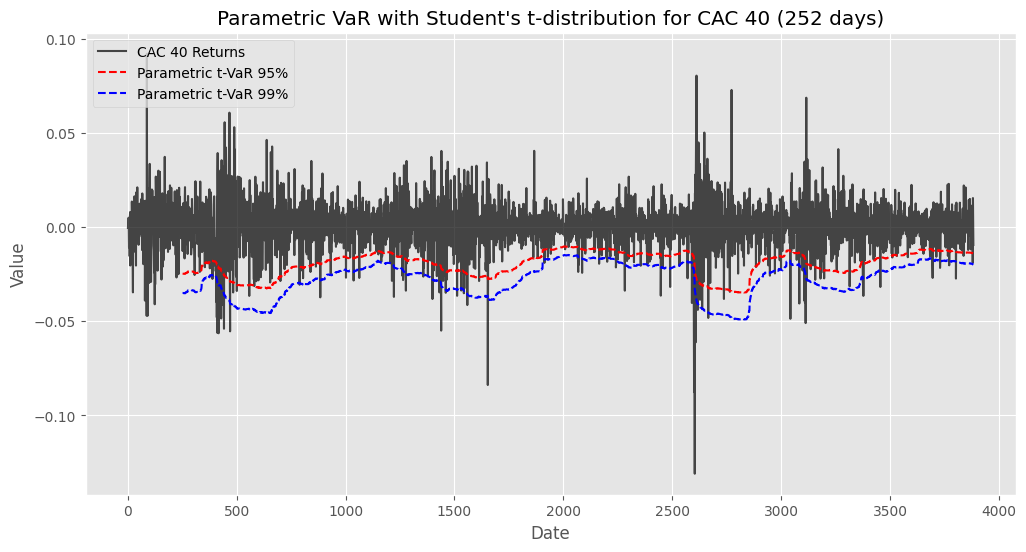

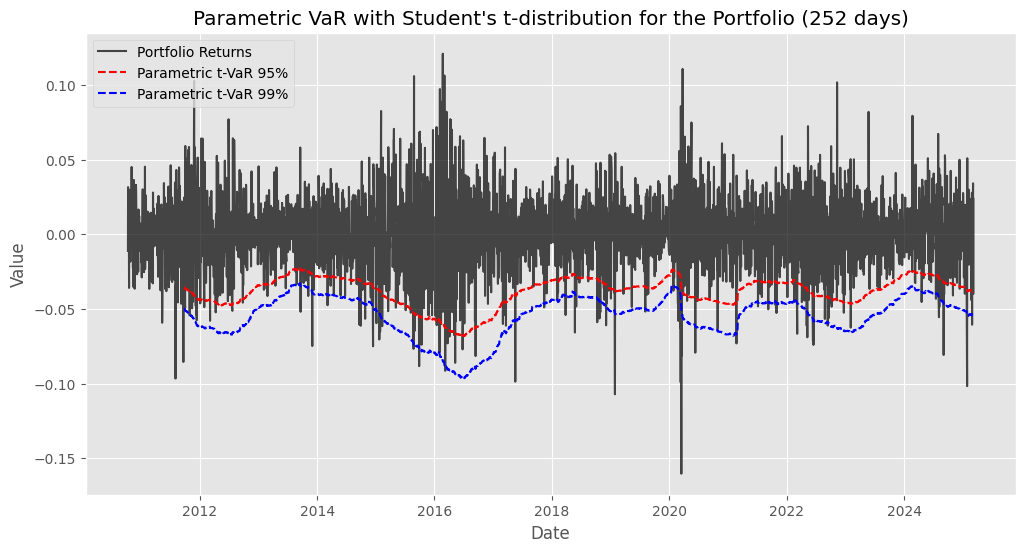

,Mean,Standard Deviation,Minimum,Maximum,Skewness,Kurtosis
CAC 40 VaR 95%,-0.019311,0.006490,-0.034684,-0.010135,-0.726729,-0.483324
Portfolio VaR 95%,-0.038315,0.010025,-0.068128,-0.022621,-0.977303,0.556308
CAC 40 VaR 99%,-0.027468,0.009075,-0.049000,-0.014712,-0.711610,-0.487380
Portfolio VaR 99%,-0.054619,0.013978,-0.096353,-0.032688,-0.993258,0.594083


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Ensure data is numeric and clean
cac40['DLCAC40'] = pd.to_numeric(cac40['DLCAC40'], errors='coerce').dropna()
portfolio_returns = pd.to_numeric(portfolio_performance['Return'], errors='coerce').dropna()

# Function to calculate Parametric VaR using the Student's t-distribution
def calculate_student_parametric_var(returns, window=252, confidence_levels=[0.95, 0.99]):
    """
    Computes the parametric Value at Risk (VaR) assuming a Student's t-distribution.

    :param returns: Time series of asset returns
    :param window: Rolling window size (default: 252 days)
    :param confidence_levels: Confidence levels for VaR calculation (default: 95% and 99%)
    :return: DataFrame with computed VaR values
    """
    var_df = pd.DataFrame(index=returns.index)

    for confidence in confidence_levels:
        df = window - 1  # Degrees of freedom (N-1)
        t_critical = stats.t.ppf(1 - confidence, df=df)  # Student's t quantile

        rolling_mean = returns.rolling(window=window).mean()
        rolling_std = returns.rolling(window=window).std()

        var_df[f'VaR_param_t_{int(confidence*100)}'] = rolling_mean + t_critical * rolling_std

    return var_df

# Compute Parametric VaR with Student's t-distribution for CAC 40 and the portfolio
cac40_param_var_results = calculate_student_parametric_var(cac40['DLCAC40'], window=252, confidence_levels=[0.95, 0.99])
portfolio_param_var_results = calculate_student_parametric_var(portfolio_returns, window=252, confidence_levels=[0.95, 0.99])

# Merge results with the original DataFrames while avoiding duplicates
cac40 = cac40.drop(columns=[col for col in ['VaR_param_t_95', 'VaR_param_t_99'] if col in cac40.columns], errors='ignore')
portfolio_performance = portfolio_performance.drop(columns=[col for col in ['VaR_param_t_95', 'VaR_param_t_99'] if col in portfolio_performance.columns], errors='ignore')

cac40 = pd.concat([cac40, cac40_param_var_results], axis=1)
portfolio_performance = pd.concat([portfolio_performance, portfolio_param_var_results], axis=1)

# Verify that required columns exist
param_var_columns = ['VaR_param_t_95', 'VaR_param_t_99']
for col in param_var_columns:
    if col not in cac40.columns or col not in portfolio_performance.columns:
        raise KeyError(f"Missing column after merging: {col}")

# Plot Parametric VaR with Student's t-distribution for CAC 40
plt.figure(figsize=(12, 6))
plt.plot(cac40.index, cac40['DLCAC40'], label="CAC 40 Returns", color='black', alpha=0.7)
plt.plot(cac40.index, cac40['VaR_param_t_95'], linestyle='dashed', color='red')
plt.plot(cac40.index, cac40['VaR_param_t_99'], linestyle='dashed', color='blue')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title("Parametric VaR with Student's t-distribution for CAC 40 (252 days)")
plt.legend(["CAC 40 Returns", "Parametric t-VaR 95%", "Parametric t-VaR 99%"], loc='upper left')
plt.grid(True)
plt.show()

# Plot Parametric VaR with Student's t-distribution for the portfolio
plt.figure(figsize=(12, 6))
plt.plot(portfolio_performance.index, portfolio_performance['Return'], label="Portfolio Returns", color='black', alpha=0.7)
plt.plot(portfolio_performance.index, portfolio_performance['VaR_param_t_95'], linestyle='dashed', color='red')
plt.plot(portfolio_performance.index, portfolio_performance['VaR_param_t_99'], linestyle='dashed', color='blue')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title("Parametric VaR with Student's t-distribution for the Portfolio (252 days)")
plt.legend(["Portfolio Returns", "Parametric t-VaR 95%", "Parametric t-VaR 99%"], loc='upper left')
plt.grid(True)
plt.show()

# Create a table with descriptive statistics
var_comparison_parametric_student = pd.DataFrame({
    "Mean": [
        cac40['VaR_param_t_95'].mean(), portfolio_performance['VaR_param_t_95'].mean(),
        cac40['VaR_param_t_99'].mean(), portfolio_performance['VaR_param_t_99'].mean()
    ],
    "Standard Deviation": [
        cac40['VaR_param_t_95'].std(), portfolio_performance['VaR_param_t_95'].std(),
        cac40['VaR_param_t_99'].std(), portfolio_performance['VaR_param_t_99'].std()
    ],
    "Minimum": [
        cac40['VaR_param_t_95'].min(), portfolio_performance['VaR_param_t_95'].min(),
        cac40['VaR_param_t_99'].min(), portfolio_performance['VaR_param_t_99'].min()
    ],
    "Maximum": [
        cac40['VaR_param_t_95'].max(), portfolio_performance['VaR_param_t_95'].max(),
        cac40['VaR_param_t_99'].max(), portfolio_performance['VaR_param_t_99'].max()
    ],
    "Skewness": [
        cac40['VaR_param_t_95'].skew(), portfolio_performance['VaR_param_t_95'].skew(),
        cac40['VaR_param_t_99'].skew(), portfolio_performance['VaR_param_t_99'].skew()
    ],
    "Kurtosis": [
        cac40['VaR_param_t_95'].kurtosis(), portfolio_performance['VaR_param_t_95'].kurtosis(),
        cac40['VaR_param_t_99'].kurtosis(), portfolio_performance['VaR_param_t_99'].kurtosis()
    ]
}, index=["CAC 40 VaR 95%", "Portfolio VaR 95%", "CAC 40 VaR 99%", "Portfolio VaR 99%"])

# Avoid duplicate indices
var_comparison_parametric_student = var_comparison_parametric_student[~var_comparison_parametric_student.index.duplicated(keep='first')]

# Display the descriptive statistics table
display(var_comparison_parametric_student)


## **4.1.3 Monte Carlo VAR**

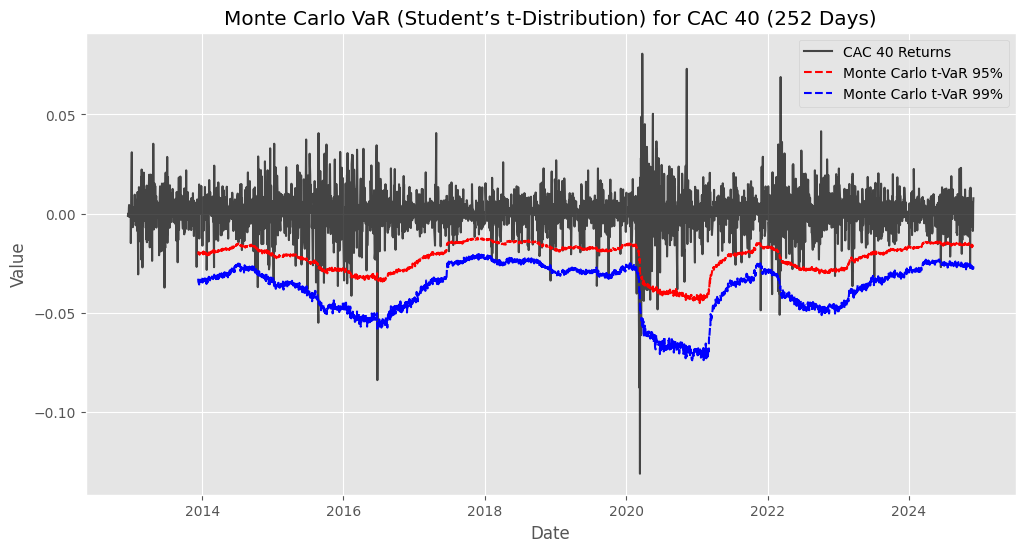

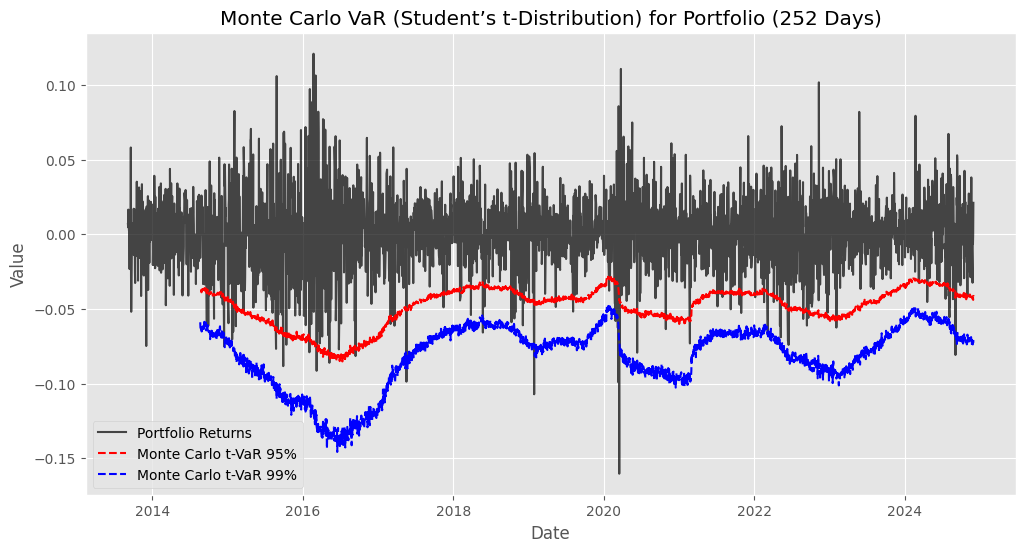

,Mean,Std Dev,Min,Max,Skewness,Kurtosis
CAC 40 Monte Carlo t-VaR 95%,-0.022290,0.007626,-0.045039,-0.012128,-1.027842,0.244727
Portfolio Monte Carlo t-VaR 95%,-0.048187,0.012663,-0.085135,-0.028360,-0.982836,0.309824
CAC 40 Monte Carlo t-VaR 99%,-0.037316,0.012579,-0.073865,-0.020322,-1.023827,0.270361
Portfolio Monte Carlo t-VaR 99%,-0.080862,0.020830,-0.145782,-0.047945,-1.004146,0.366283


In [ ]:
# Ensure data is numeric and cleaned
cac40['DLCAC40'] = pd.to_numeric(cac40['DLCAC40'], errors='coerce').dropna()
portfolio_returns = pd.to_numeric(portfolio_performance['Return'], errors='coerce').dropna()

# Monte Carlo VaR Function using Student’s t-Distribution
def calculate_monte_carlo_var_student(returns, window=252, simulations=10000, confidence_levels=[0.95, 0.99], df=5):
    """
    Computes Monte Carlo VaR using Student’s t-Distribution.

    - returns: Series of returns
    - window: Rolling window size (default: 252 days)
    - simulations: Number of Monte Carlo simulations
    - confidence_levels: List of confidence levels (e.g., [0.95, 0.99])
    - df: Degrees of freedom for Student’s t-distribution (default: 5)
    """
    var_df = pd.DataFrame(index=returns.index)

    for confidence in confidence_levels:
        rolling_data = returns.rolling(window=window)

        def simulate_var(subset):
            if len(subset.dropna()) < window:
                return np.nan  # Not enough data

            mu = subset.mean()  # Mean return
            sigma = subset.std()  # Standard deviation

            # Generate simulations using Student's t-distribution
            simulated_returns = mu + sigma * np.random.standard_t(df, size=simulations)

            # Compute the VaR as the empirical quantile
            return np.percentile(simulated_returns, (1 - confidence) * 100)

        # Apply Monte Carlo simulation with Student's t-distribution
        var_df[f'VaR_MC_t_{int(confidence*100)}'] = rolling_data.apply(simulate_var, raw=False)

    return var_df

# Compute Monte Carlo VaR for CAC 40 & Portfolio using Student's t-distribution
cac40_mc_t_var_results = calculate_monte_carlo_var_student(
    cac40['DLCAC40'], window=252, simulations=10000, confidence_levels=[0.95, 0.99], df=5
)

portfolio_mc_t_var_results = calculate_monte_carlo_var_student(
    portfolio_returns, window=252, simulations=10000, confidence_levels=[0.95, 0.99], df=5
)

# Remove existing Monte Carlo VaR columns to avoid duplication
cac40 = cac40.drop(columns=[col for col in ['VaR_MC_t_95', 'VaR_MC_t_99'] if col in cac40.columns], errors='ignore')
portfolio_performance = portfolio_performance.drop(columns=[col for col in ['VaR_MC_t_95', 'VaR_MC_t_99'] if col in portfolio_performance.columns], errors='ignore')

# Merge results into the DataFrames
cac40 = pd.concat([cac40, cac40_mc_t_var_results], axis=1)
portfolio_performance = pd.concat([portfolio_performance, portfolio_mc_t_var_results], axis=1)

# Verify the expected columns exist
mc_t_var_columns = ['VaR_MC_t_95', 'VaR_MC_t_99']
for col in mc_t_var_columns:
    if col not in cac40.columns or col not in portfolio_performance.columns:
        raise KeyError(f"Missing column: {col}")

# Plot Monte Carlo VaR (Student's t-Distribution) for CAC 40
plt.figure(figsize=(12, 6))
plt.plot(cac40.index, cac40['DLCAC40'], label="CAC 40 Returns", color='black', alpha=0.7)
plt.plot(cac40.index, cac40['VaR_MC_t_95'], linestyle='dashed', color='red', label="Monte Carlo t-VaR 95%")
plt.plot(cac40.index, cac40['VaR_MC_t_99'], linestyle='dashed', color='blue', label="Monte Carlo t-VaR 99%")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Monte Carlo VaR (Student’s t-Distribution) for CAC 40 (252 Days)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Monte Carlo VaR (Student's t-Distribution) for Portfolio
plt.figure(figsize=(12, 6))
plt.plot(portfolio_performance.index, portfolio_performance['Return'], label="Portfolio Returns", color='black', alpha=0.7)
plt.plot(portfolio_performance.index, portfolio_performance['VaR_MC_t_95'], linestyle='dashed', color='red', label="Monte Carlo t-VaR 95%")
plt.plot(portfolio_performance.index, portfolio_performance['VaR_MC_t_99'], linestyle='dashed', color='blue', label="Monte Carlo t-VaR 99%")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Monte Carlo VaR (Student’s t-Distribution) for Portfolio (252 Days)")
plt.legend()
plt.grid(True)
plt.show()

# Create Summary Statistics Table
var_comparison_mc_t = pd.DataFrame({
    "Mean": [
        cac40['VaR_MC_t_95'].mean(), portfolio_performance['VaR_MC_t_95'].mean(),
        cac40['VaR_MC_t_99'].mean(), portfolio_performance['VaR_MC_t_99'].mean()
    ],
    "Std Dev": [
        cac40['VaR_MC_t_95'].std(), portfolio_performance['VaR_MC_t_95'].std(),
        cac40['VaR_MC_t_99'].std(), portfolio_performance['VaR_MC_t_99'].std()
    ],
    "Min": [
        cac40['VaR_MC_t_95'].min(), portfolio_performance['VaR_MC_t_95'].min(),
        cac40['VaR_MC_t_99'].min(), portfolio_performance['VaR_MC_t_99'].min()
    ],
    "Max": [
        cac40['VaR_MC_t_95'].max(), portfolio_performance['VaR_MC_t_95'].max(),
        cac40['VaR_MC_t_99'].max(), portfolio_performance['VaR_MC_t_99'].max()
    ],
    "Skewness": [
        cac40['VaR_MC_t_95'].skew(), portfolio_performance['VaR_MC_t_95'].skew(),
        cac40['VaR_MC_t_99'].skew(), portfolio_performance['VaR_MC_t_99'].skew()
    ],
    "Kurtosis": [
        cac40['VaR_MC_t_95'].kurtosis(), portfolio_performance['VaR_MC_t_95'].kurtosis(),
        cac40['VaR_MC_t_99'].kurtosis(), portfolio_performance['VaR_MC_t_99'].kurtosis()
    ]
}, index=["CAC 40 Monte Carlo t-VaR 95%", "Portfolio Monte Carlo t-VaR 95%", "CAC 40 Monte Carlo t-VaR 99%", "Portfolio Monte Carlo t-VaR 99%"])

# Display Final Summary Table
display(var_comparison_mc_t)


## **4.2.1 Historical CVAR**

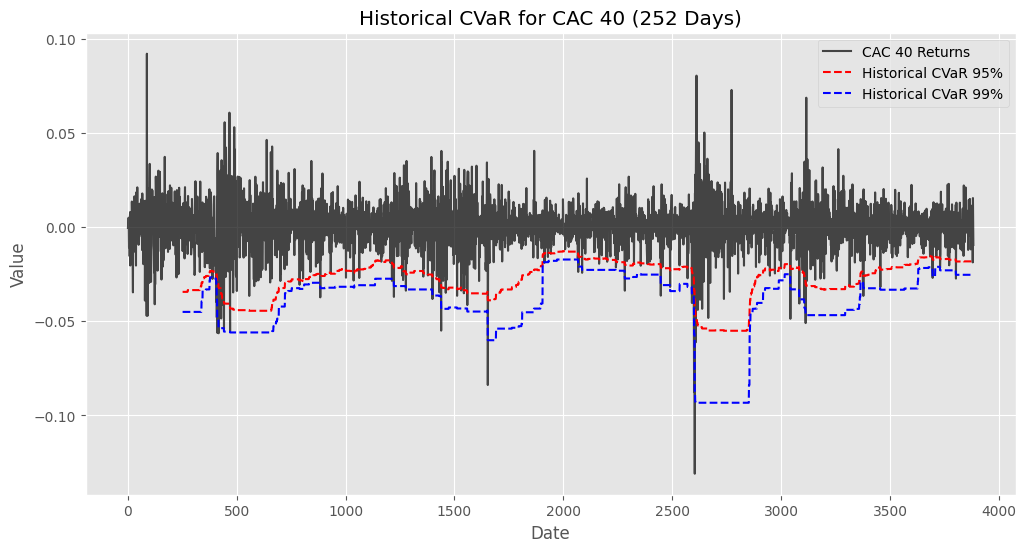

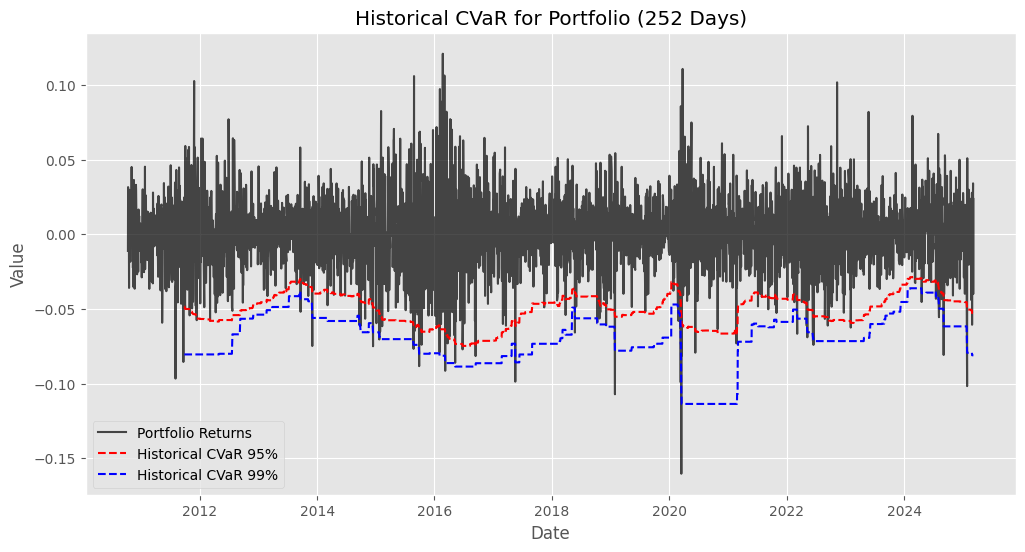

,Mean,Std Dev,Min,Max,Skewness,Kurtosis
CAC 40 CVaR 95%,-0.027510,0.010536,-0.055013,-0.012714,-1.101504,0.639809
Portfolio CVaR 95%,-0.050430,0.011004,-0.074743,-0.028423,-0.209539,-0.684523
CAC 40 CVaR 99%,-0.039454,0.018065,-0.093270,-0.017154,-1.674113,2.726251
Portfolio CVaR 99%,-0.069435,0.017637,-0.113602,-0.036101,-0.704502,0.674715


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Ensure data is numeric and cleaned
cac40['DLCAC40'] = pd.to_numeric(cac40['DLCAC40'], errors='coerce').dropna()
portfolio_returns = pd.to_numeric(portfolio_performance['Return'], errors='coerce').dropna()

# Function to calculate Historical CVaR
def calculate_historical_cvar(returns, window=252, confidence_levels=[0.95, 0.99]):
    """
    Computes Historical CVaR by taking the mean of losses beyond the VaR over a rolling window.

    :param returns: Series of asset returns
    :param window: Rolling window size (default: 252 days)
    :param confidence_levels: List of confidence levels (e.g., [0.95, 0.99])
    :return: DataFrame containing Historical CVaR estimates
    """
    cvar_df = pd.DataFrame(index=returns.index)

    for confidence in confidence_levels:
        var_series = returns.rolling(window=window).quantile(1 - confidence)

        def expected_shortfall(subset):
            threshold = np.nanquantile(subset, 1 - confidence)
            return subset[subset <= threshold].mean()

        cvar_df[f'CVaR_Histo_{int(confidence*100)}'] = returns.rolling(window=window).apply(expected_shortfall, raw=True)

    return cvar_df

# Compute Historical CVaR for CAC 40 and Portfolio
cac40_histo_cvar_results = calculate_historical_cvar(cac40['DLCAC40'], window=252, confidence_levels=[0.95, 0.99])
portfolio_histo_cvar_results = calculate_historical_cvar(portfolio_returns, window=252, confidence_levels=[0.95, 0.99])

# Remove existing CVaR columns to avoid duplication
cac40 = cac40.drop(columns=[col for col in ['CVaR_Histo_95', 'CVaR_Histo_99'] if col in cac40.columns], errors='ignore')
portfolio_performance = portfolio_performance.drop(columns=[col for col in ['CVaR_Histo_95', 'CVaR_Histo_99'] if col in portfolio_performance.columns], errors='ignore')

# Merge results into the DataFrames
cac40 = pd.concat([cac40, cac40_histo_cvar_results], axis=1)
portfolio_performance = pd.concat([portfolio_performance, portfolio_histo_cvar_results], axis=1)

# Verify the expected columns exist
histo_cvar_columns = ['CVaR_Histo_95', 'CVaR_Histo_99']
for col in histo_cvar_columns:
    if col not in cac40.columns or col not in portfolio_performance.columns:
        raise KeyError(f"Missing column: {col}")

# Plot Historical CVaR for CAC 40
plt.figure(figsize=(12, 6))
plt.plot(cac40.index, cac40['DLCAC40'], label="CAC 40 Returns", color='black', alpha=0.7)
plt.plot(cac40.index, cac40['CVaR_Histo_95'], linestyle='dashed', color='red', label="Historical CVaR 95%")
plt.plot(cac40.index, cac40['CVaR_Histo_99'], linestyle='dashed', color='blue', label="Historical CVaR 99%")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Historical CVaR for CAC 40 (252 Days)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Historical CVaR for Portfolio
plt.figure(figsize=(12, 6))
plt.plot(portfolio_performance.index, portfolio_performance['Return'], label="Portfolio Returns", color='black', alpha=0.7)
plt.plot(portfolio_performance.index, portfolio_performance['CVaR_Histo_95'], linestyle='dashed', color='red', label="Historical CVaR 95%")
plt.plot(portfolio_performance.index, portfolio_performance['CVaR_Histo_99'], linestyle='dashed', color='blue', label="Historical CVaR 99%")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Historical CVaR for Portfolio (252 Days)")
plt.legend()
plt.grid(True)
plt.show()

# Create Summary Statistics Table
cvar_comparison_histo = pd.DataFrame({
    "Mean": [
        cac40['CVaR_Histo_95'].mean(), portfolio_performance['CVaR_Histo_95'].mean(),
        cac40['CVaR_Histo_99'].mean(), portfolio_performance['CVaR_Histo_99'].mean()
    ],
    "Std Dev": [
        cac40['CVaR_Histo_95'].std(), portfolio_performance['CVaR_Histo_95'].std(),
        cac40['CVaR_Histo_99'].std(), portfolio_performance['CVaR_Histo_99'].std()
    ],
    "Min": [
        cac40['CVaR_Histo_95'].min(), portfolio_performance['CVaR_Histo_95'].min(),
        cac40['CVaR_Histo_99'].min(), portfolio_performance['CVaR_Histo_99'].min()
    ],
    "Max": [
        cac40['CVaR_Histo_95'].max(), portfolio_performance['CVaR_Histo_95'].max(),
        cac40['CVaR_Histo_99'].max(), portfolio_performance['CVaR_Histo_99'].max()
    ],
    "Skewness": [
        cac40['CVaR_Histo_95'].skew(), portfolio_performance['CVaR_Histo_95'].skew(),
        cac40['CVaR_Histo_99'].skew(), portfolio_performance['CVaR_Histo_99'].skew()
    ],
    "Kurtosis": [
        cac40['CVaR_Histo_95'].kurtosis(), portfolio_performance['CVaR_Histo_95'].kurtosis(),
        cac40['CVaR_Histo_99'].kurtosis(), portfolio_performance['CVaR_Histo_99'].kurtosis()
    ]
}, index=["CAC 40 CVaR 95%", "Portfolio CVaR 95%", "CAC 40 CVaR 99%", "Portfolio CVaR 99%"])

# Remove duplicate indices if any
cvar_comparison_histo = cvar_comparison_histo[~cvar_comparison_histo.index.duplicated(keep='first')]

# Display Summary Table
display(cvar_comparison_histo)


## **4.2.2 Parametric CVAR**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Ensure data is numeric and cleaned
cac40['DLCAC40'] = pd.to_numeric(cac40['DLCAC40'], errors='coerce').dropna()
portfolio_returns = pd.to_numeric(portfolio_performance['Return'], errors='coerce').dropna()

# Optimized Function to Compute Parametric CVaR using Student's t-Distribution
def calculate_student_parametric_cvar(returns, window=252, confidence_levels=[0.95, 0.99]):
    """
    Computes Conditional Value at Risk (CVaR) using a Student's t-distribution assumption.

    Parameters:
    - returns: Series of asset returns
    - window: Rolling window size (default: 252 days)
    - confidence_levels: List of confidence levels (e.g., [0.95, 0.99])

    Returns:
    - DataFrame containing CVaR estimates
    """
    cvar_df = pd.DataFrame(index=returns.index)

    for confidence in confidence_levels:
        rolling_data = returns.rolling(window=window)

        def compute_cvar(subset):
            if len(subset.dropna()) < window:
                return np.nan  # Not enough data

            # Fit Student's t-distribution to the rolling data
            df, loc, scale = stats.t.fit(subset.dropna())

            # Compute VaR (Value at Risk)
            var_value = stats.t.ppf(1 - confidence, df=df, loc=loc, scale=scale)

            # Compute CVaR (Expected Shortfall beyond VaR)
            cvar_value = (df + var_value**2) / (df - 1) * stats.t.pdf(var_value, df=df, loc=loc, scale=scale)

            return loc - scale * cvar_value

        # Apply rolling CVaR calculation
        cvar_df[f'CVaR_param_t_{int(confidence*100)}'] = rolling_data.apply(compute_cvar, raw=False)

    return cvar_df

# Compute Parametric CVaR for CAC 40 and Portfolio
cac40_param_cvar_results = calculate_student_parametric_cvar(cac40['DLCAC40'], window=252, confidence_levels=[0.95, 0.99])
portfolio_param_cvar_results = calculate_student_parametric_cvar(portfolio_returns, window=252, confidence_levels=[0.95, 0.99])

# Remove existing CVaR columns to avoid duplication
cac40.drop(columns=['CVaR_param_t_95', 'CVaR_param_t_99'], errors='ignore', inplace=True)
portfolio_performance.drop(columns=['CVaR_param_t_95', 'CVaR_param_t_99'], errors='ignore', inplace=True)

# Merge results into the DataFrames
cac40 = pd.concat([cac40, cac40_param_cvar_results], axis=1)
portfolio_performance = pd.concat([portfolio_performance, portfolio_param_cvar_results], axis=1)

# Verify expected columns exist
param_cvar_columns = ['CVaR_param_t_95', 'CVaR_param_t_99']
for col in param_cvar_columns:
    if col not in cac40.columns or col not in portfolio_performance.columns:
        raise KeyError(f"Missing column: {col}")

# Plot Parametric CVaR for CAC 40
plt.figure(figsize=(12, 6))
plt.plot(cac40.index, cac40['DLCAC40'], label="CAC 40 Returns", color='black', alpha=0.7)
plt.plot(cac40.index, cac40['CVaR_param_t_95'], linestyle='dashed', color='red', label="Parametric t-CVaR 95%")
plt.plot(cac40.index, cac40['CVaR_param_t_99'], linestyle='dashed', color='blue', label="Parametric t-CVaR 99%")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Parametric CVaR (Student's t-Distribution) for CAC 40 (252 Days)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Parametric CVaR for Portfolio
plt.figure(figsize=(12, 6))
plt.plot(portfolio_performance.index, portfolio_performance['Return'], label="Portfolio Returns", color='black', alpha=0.7)
plt.plot(portfolio_performance.index, portfolio_performance['CVaR_param_t_95'], linestyle='dashed', color='red', label="Parametric t-CVaR 95%")
plt.plot(portfolio_performance.index, portfolio_performance['CVaR_param_t_99'], linestyle='dashed', color='blue', label="Parametric t-CVaR 99%")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Parametric CVaR (Student's t-Distribution) for Portfolio (252 Days)")
plt.legend()
plt.grid(True)
plt.show()

# Create Summary Statistics Table
cvar_comparison_parametric_student = pd.DataFrame({
    "Mean": [
        cac40['CVaR_param_t_95'].mean(), portfolio_performance['CVaR_param_t_95'].mean(),
        cac40['CVaR_param_t_99'].mean(), portfolio_performance['CVaR_param_t_99'].mean()
    ],
    "Std Dev": [
        cac40['CVaR_param_t_95'].std(), portfolio_performance['CVaR_param_t_95'].std(),
        cac40['CVaR_param_t_99'].std(), portfolio_performance['CVaR_param_t_99'].std()
    ],
    "Min": [
        cac40['CVaR_param_t_95'].min(), portfolio_performance['CVaR_param_t_95'].min(),
        cac40['CVaR_param_t_99'].min(), portfolio_performance['CVaR_param_t_99'].min()
    ],
    "Max": [
        cac40['CVaR_param_t_95'].max(), portfolio_performance['CVaR_param_t_95'].max(),
        cac40['CVaR_param_t_99'].max(), portfolio_performance['CVaR_param_t_99'].max()
    ],
    "Skewness": [
        cac40['CVaR_param_t_95'].skew(), portfolio_performance['CVaR_param_t_95'].skew(),
        cac40['CVaR_param_t_99'].skew(), portfolio_performance['CVaR_param_t_99'].skew()
    ],
    "Kurtosis": [
        cac40['CVaR_param_t_95'].kurtosis(), portfolio_performance['CVaR_param_t_95'].kurtosis(),
        cac40['CVaR_param_t_99'].kurtosis(), portfolio_performance['CVaR_param_t_99'].kurtosis()
    ]
}, index=["CAC 40 CVaR 95%", "Portfolio CVaR 95%", "CAC 40 CVaR 99%", "Portfolio CVaR 99%"])

# Remove duplicate indices if any
cvar_comparison_parametric_student = cvar_comparison_parametric_student[~cvar_comparison_parametric_student.index.duplicated(keep='first')]

# Display Summary Table
display(cvar_comparison_parametric_student)


## **4.2.3 Monte Carlo CVAR**

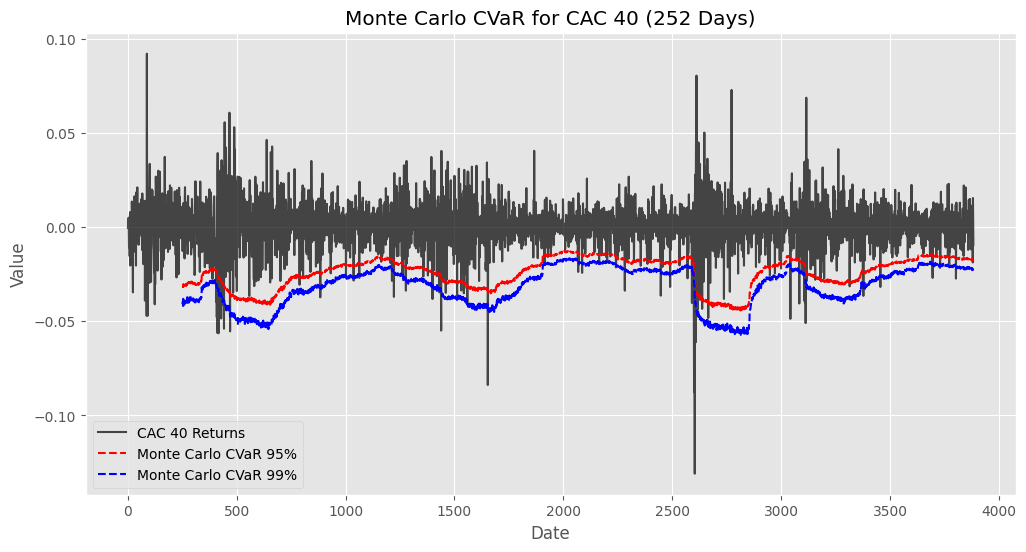

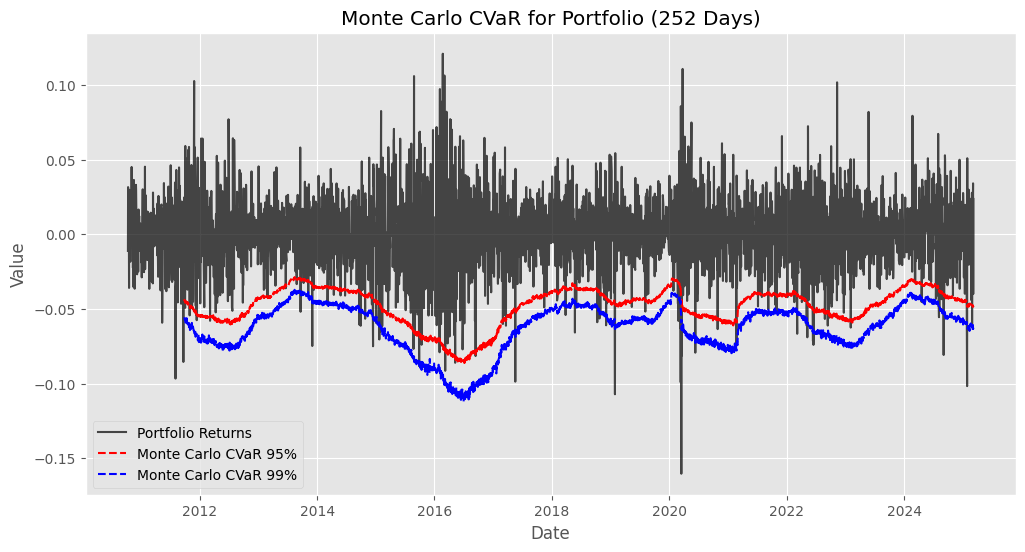

,Mean,Std Dev,Min,Max,Skewness,Kurtosis
CAC 40 CVaR 95%,-0.024168,0.008037,-0.044252,-0.012673,-0.719000,-0.477650
Portfolio CVaR 95%,-0.048017,0.012387,-0.086108,-0.028287,-0.984372,0.576547
CAC 40 CVaR 99%,-0.031264,0.010304,-0.057481,-0.016611,-0.715393,-0.467050
Portfolio CVaR 99%,-0.062222,0.015859,-0.112516,-0.037139,-0.997960,0.611088


In [ ]:
# Ensure data is numeric and cleaned
cac40['DLCAC40'] = pd.to_numeric(cac40['DLCAC40'], errors='coerce').dropna()
portfolio_returns = pd.to_numeric(portfolio_performance['Return'], errors='coerce').dropna()

# Monte Carlo CVaR Function
def calculate_monte_carlo_cvar(returns, window=252, simulations=10000, confidence_levels=[0.95, 0.99]):
    """
    Computes Conditional Value at Risk (CVaR) using Monte Carlo simulations.

    Parameters:
    - returns: Series of asset returns
    - window: Rolling window size (default: 252 days)
    - simulations: Number of Monte Carlo simulations
    - confidence_levels: List of confidence levels (e.g., [0.95, 0.99])

    Returns:
    - DataFrame containing CVaR estimates
    """
    cvar_df = pd.DataFrame(index=returns.index)

    for confidence in confidence_levels:
        rolling_data = returns.rolling(window=window)

        def simulate_cvar(subset):
            if len(subset.dropna()) < window:
                return np.nan  # Not enough data

            mu = subset.mean()  # Rolling mean
            sigma = subset.std()  # Rolling standard deviation

            # Generate Monte Carlo simulations
            simulated_returns = np.random.normal(mu, sigma, size=simulations)

            # Compute Monte Carlo VaR
            var_value = np.percentile(simulated_returns, (1 - confidence) * 100)

            # Compute CVaR as the average loss beyond the VaR threshold
            cvar_value = simulated_returns[simulated_returns <= var_value].mean()

            return cvar_value

        # Apply Monte Carlo simulation to the time series
        cvar_df[f'CVaR_MC_{int(confidence*100)}'] = rolling_data.apply(simulate_cvar, raw=False)

    return cvar_df

# Compute Monte Carlo CVaR for CAC 40 and Portfolio
cac40_mc_cvar_results = calculate_monte_carlo_cvar(cac40['DLCAC40'], window=252, simulations=10000, confidence_levels=[0.95, 0.99])
portfolio_mc_cvar_results = calculate_monte_carlo_cvar(portfolio_returns, window=252, simulations=10000, confidence_levels=[0.95, 0.99])

# Remove existing Monte Carlo CVaR columns to avoid duplication
cac40.drop(columns=['CVaR_MC_95', 'CVaR_MC_99'], errors='ignore', inplace=True)
portfolio_performance.drop(columns=['CVaR_MC_95', 'CVaR_MC_99'], errors='ignore', inplace=True)

# Merge results into the DataFrames
cac40 = pd.concat([cac40, cac40_mc_cvar_results], axis=1)
portfolio_performance = pd.concat([portfolio_performance, portfolio_mc_cvar_results], axis=1)

# Verify expected columns exist
mc_cvar_columns = ['CVaR_MC_95', 'CVaR_MC_99']
for col in mc_cvar_columns:
    if col not in cac40.columns or col not in portfolio_performance.columns:
        raise KeyError(f"Missing column: {col}")

# Plot Monte Carlo CVaR for CAC 40
plt.figure(figsize=(12, 6))
plt.plot(cac40.index, cac40['DLCAC40'], label="CAC 40 Returns", color='black', alpha=0.7)
plt.plot(cac40.index, cac40['CVaR_MC_95'], linestyle='dashed', color='red', label="Monte Carlo CVaR 95%")
plt.plot(cac40.index, cac40['CVaR_MC_99'], linestyle='dashed', color='blue', label="Monte Carlo CVaR 99%")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Monte Carlo CVaR for CAC 40 (252 Days)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Monte Carlo CVaR for Portfolio
plt.figure(figsize=(12, 6))
plt.plot(portfolio_performance.index, portfolio_performance['Return'], label="Portfolio Returns", color='black', alpha=0.7)
plt.plot(portfolio_performance.index, portfolio_performance['CVaR_MC_95'], linestyle='dashed', color='red', label="Monte Carlo CVaR 95%")
plt.plot(portfolio_performance.index, portfolio_performance['CVaR_MC_99'], linestyle='dashed', color='blue', label="Monte Carlo CVaR 99%")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Monte Carlo CVaR for Portfolio (252 Days)")
plt.legend()
plt.grid(True)
plt.show()

# Create Summary Statistics Table
cvar_comparison_mc = pd.DataFrame({
    "Mean": [
        cac40['CVaR_MC_95'].mean(), portfolio_performance['CVaR_MC_95'].mean(),
        cac40['CVaR_MC_99'].mean(), portfolio_performance['CVaR_MC_99'].mean()
    ],
    "Std Dev": [
        cac40['CVaR_MC_95'].std(), portfolio_performance['CVaR_MC_95'].std(),
        cac40['CVaR_MC_99'].std(), portfolio_performance['CVaR_MC_99'].std()
    ],
    "Min": [
        cac40['CVaR_MC_95'].min(), portfolio_performance['CVaR_MC_95'].min(),
        cac40['CVaR_MC_99'].min(), portfolio_performance['CVaR_MC_99'].min()
    ],
    "Max": [
        cac40['CVaR_MC_95'].max(), portfolio_performance['CVaR_MC_95'].max(),
        cac40['CVaR_MC_99'].max(), portfolio_performance['CVaR_MC_99'].max()
    ],
    "Skewness": [
        cac40['CVaR_MC_95'].skew(), portfolio_performance['CVaR_MC_95'].skew(),
        cac40['CVaR_MC_99'].skew(), portfolio_performance['CVaR_MC_99'].skew()
    ],
    "Kurtosis": [
        cac40['CVaR_MC_95'].kurtosis(), portfolio_performance['CVaR_MC_95'].kurtosis(),
        cac40['CVaR_MC_99'].kurtosis(), portfolio_performance['CVaR_MC_99'].kurtosis()
    ]
}, index=["CAC 40 CVaR 95%", "Portfolio CVaR 95%", "CAC 40 CVaR 99%", "Portfolio CVaR 99%"])

# Remove duplicate indices if any
cvar_comparison_mc = cvar_comparison_mc[~cvar_comparison_mc.index.duplicated(keep='first')]

# Display Summary Table
display(cvar_comparison_mc)


## **5. Backtesting**

## 5.1 Kupiec

5.1.1. Kupiec Test with Historical VAR

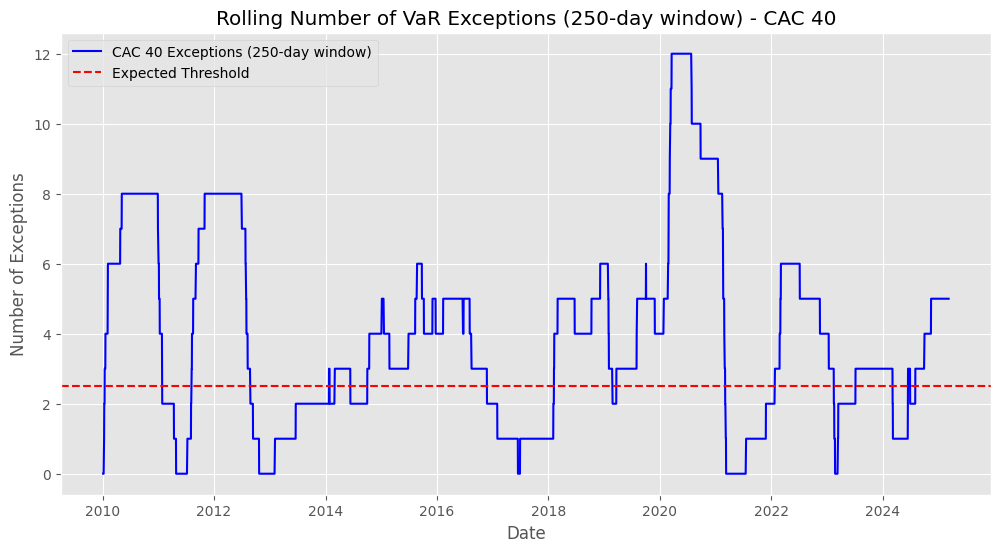

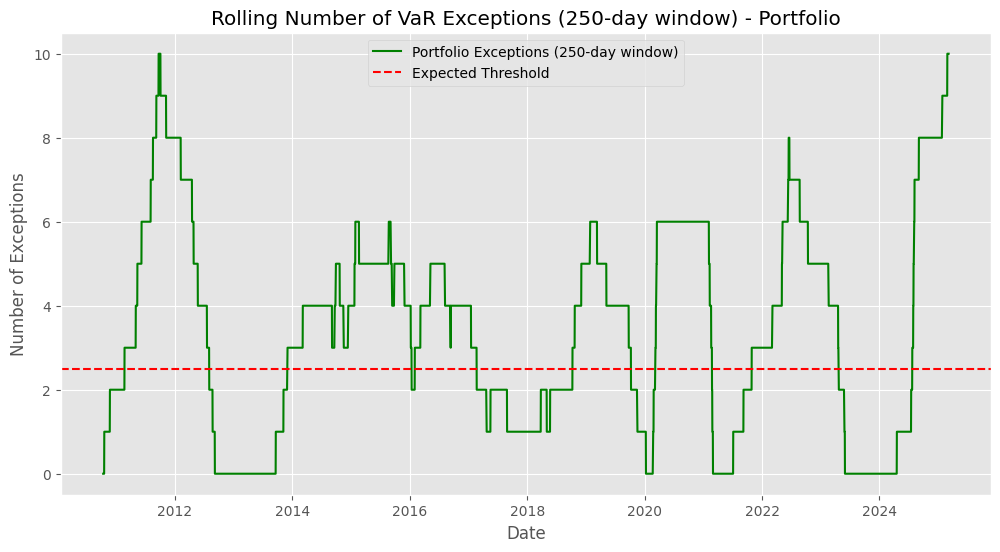

'\n--- CAC 40 Kupiec Test Results ---'

,VaR_99,Exception_Count,Kupiec_p_value
Date,,,
2025-02-24,-0.020936,5.0,0.161855
2025-02-25,-0.020936,5.0,0.161855
2025-02-26,-0.020936,5.0,0.161855
2025-02-27,-0.020936,5.0,0.161855
2025-02-28,-0.020936,5.0,0.161855
2025-03-03,-0.020936,5.0,0.161855
2025-03-04,-0.020936,5.0,0.161855
2025-03-05,-0.020936,5.0,0.161855
2025-03-06,-0.020936,5.0,0.161855


'\n--- Portfolio Kupiec Test Results ---'

,VaR_99,Exception_Count,Kupiec_p_value
Date,,,
2025-02-24,-0.052126,9.0,0.001382
2025-02-25,-0.052126,9.0,0.001382
2025-02-26,-0.052126,9.0,0.001382
2025-02-27,-0.058069,10.0,0.000319
2025-02-28,-0.058069,10.0,0.000319
2025-03-03,-0.058069,10.0,0.000319
2025-03-04,-0.058069,10.0,0.000319
2025-03-05,-0.058069,10.0,0.000319
2025-03-06,-0.058069,10.0,0.000319


In [ ]:

# Ensure data is numeric and cleaned
cac40['DLCAC40'] = pd.to_numeric(cac40['DLCAC40'], errors='coerce').dropna()
portfolio_performance['Return'] = pd.to_numeric(portfolio_performance['Return'], errors='coerce').dropna()

# Define parameters
confidence_level = 0.99
window_size = 250  # 250-day rolling window

# Ensure Date Columns Exist and Convert to Datetime
if 'Date' in cac40.columns:
    cac40['Date'] = pd.to_datetime(cac40['Date'])
    cac40.set_index('Date', inplace=True)

if 'Date' in portfolio_performance.columns:
    portfolio_performance['Date'] = pd.to_datetime(portfolio_performance['Date'])
    portfolio_performance.set_index('Date', inplace=True)

# Compute Historical VaR (99% confidence level) for both datasets
cac40['VaR_99'] = cac40['DLCAC40'].rolling(window=window_size, min_periods=1).quantile(1 - confidence_level)
portfolio_performance['VaR_99'] = portfolio_performance['Return'].rolling(window=window_size, min_periods=1).quantile(1 - confidence_level)

# Identify exceptions (when returns fall below VaR)
cac40['Exception'] = (cac40['DLCAC40'] < cac40['VaR_99']).astype(int)
portfolio_performance['Exception'] = (portfolio_performance['Return'] < portfolio_performance['VaR_99']).astype(int)

# Count exceptions over a rolling 250-day window
cac40['Exception_Count'] = cac40['Exception'].rolling(window=window_size, min_periods=1).sum()
portfolio_performance['Exception_Count'] = portfolio_performance['Exception'].rolling(window=window_size, min_periods=1).sum()

# Kupiec Test Function
def kupiec_test(num_exceptions, total_obs, var_level):
    """
    Kupiec likelihood ratio test for validating the exception frequency of VaR.

    Parameters:
    - num_exceptions: observed number of exceptions
    - total_obs: total number of observations (e.g., 250 days)
    - var_level: confidence level of VaR (e.g., 0.99)

    Returns:
    - p-value from the chi-squared test
    """
    if num_exceptions == 0 or num_exceptions == total_obs:  # Avoid log(0) issue
        return 1.0

    p_hat = num_exceptions / total_obs  # Observed exception frequency
    p_expected = 1 - var_level  # Expected exception frequency

    log_likelihood_ratio = -2 * np.log(
        ((1 - p_expected) ** (total_obs - num_exceptions) * (p_expected ** num_exceptions)) /
        ((1 - p_hat) ** (total_obs - num_exceptions) * (p_hat ** num_exceptions))
    )

    return 1 - stats.chi2.cdf(log_likelihood_ratio, df=1)  # Chi-squared test with 1 degree of freedom

# Apply Kupiec Test Efficiently
cac40['Kupiec_p_value'] = np.nan
portfolio_performance['Kupiec_p_value'] = np.nan

valid_indices_cac40 = cac40.index[window_size-1:]  # Avoid unnecessary computation
valid_indices_portfolio = portfolio_performance.index[window_size-1:]

for i in valid_indices_cac40:
    start_index = i - pd.DateOffset(days=window_size-1)  # Corrected subtraction
    num_exceptions = cac40.loc[start_index:i, 'Exception_Count'].iloc[-1]
    cac40.loc[i, 'Kupiec_p_value'] = kupiec_test(num_exceptions, window_size, confidence_level)

for i in valid_indices_portfolio:
    start_index = i - pd.DateOffset(days=window_size-1)  # Corrected subtraction
    num_exceptions = portfolio_performance.loc[start_index:i, 'Exception_Count'].iloc[-1]
    portfolio_performance.loc[i, 'Kupiec_p_value'] = kupiec_test(num_exceptions, window_size, confidence_level)

# Plot Rolling Exception Count for CAC 40
plt.figure(figsize=(12, 6))
plt.plot(cac40.index, cac40['Exception_Count'], label="CAC 40 Exceptions (250-day window)", color='blue')
plt.axhline(y=window_size * (1 - confidence_level), color='red', linestyle='--', label="Expected Threshold")
plt.xlabel("Date")
plt.ylabel("Number of Exceptions")
plt.title("Rolling Number of VaR Exceptions (250-day window) - CAC 40")
plt.legend()
plt.grid(True)
plt.show()

# Plot Rolling Exception Count for Portfolio
plt.figure(figsize=(12, 6))
plt.plot(portfolio_performance.index, portfolio_performance['Exception_Count'], label="Portfolio Exceptions (250-day window)", color='green')
plt.axhline(y=window_size * (1 - confidence_level), color='red', linestyle='--', label="Expected Threshold")
plt.xlabel("Date")
plt.ylabel("Number of Exceptions")
plt.title("Rolling Number of VaR Exceptions (250-day window) - Portfolio")
plt.legend()
plt.grid(True)
plt.show()

# Display final results
display("\n--- CAC 40 Kupiec Test Results ---")
display(cac40[['VaR_99', 'Exception_Count', 'Kupiec_p_value']].dropna().tail(10))  # Show last 10 results

display("\n--- Portfolio Kupiec Test Results ---")
display(portfolio_performance[['VaR_99', 'Exception_Count', 'Kupiec_p_value']].dropna().tail(10))  # Show last 10 results


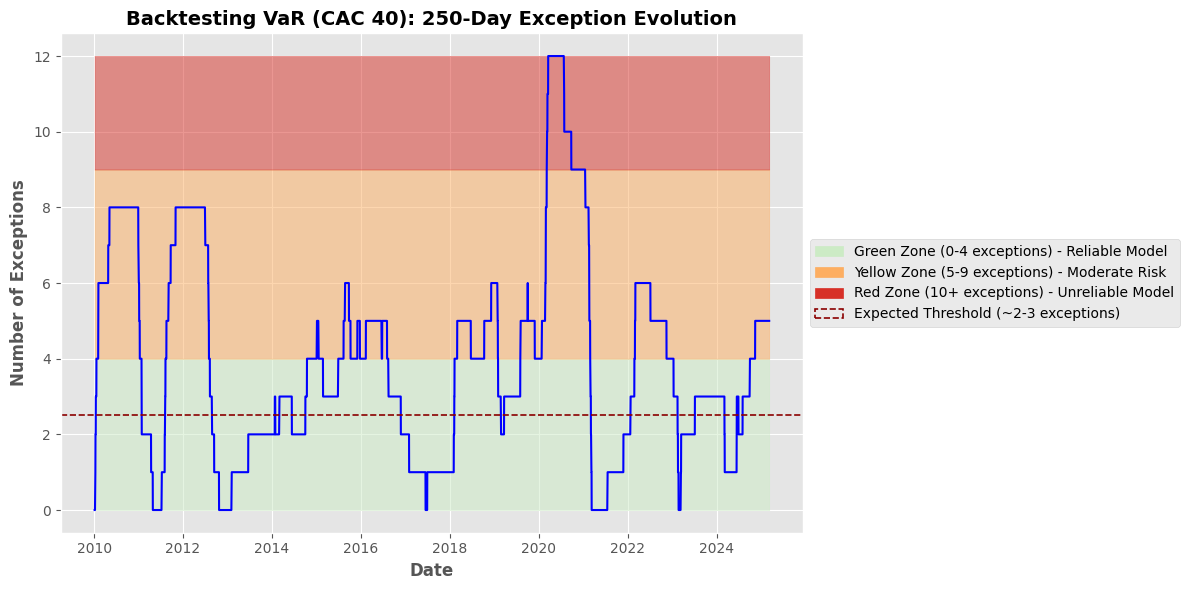

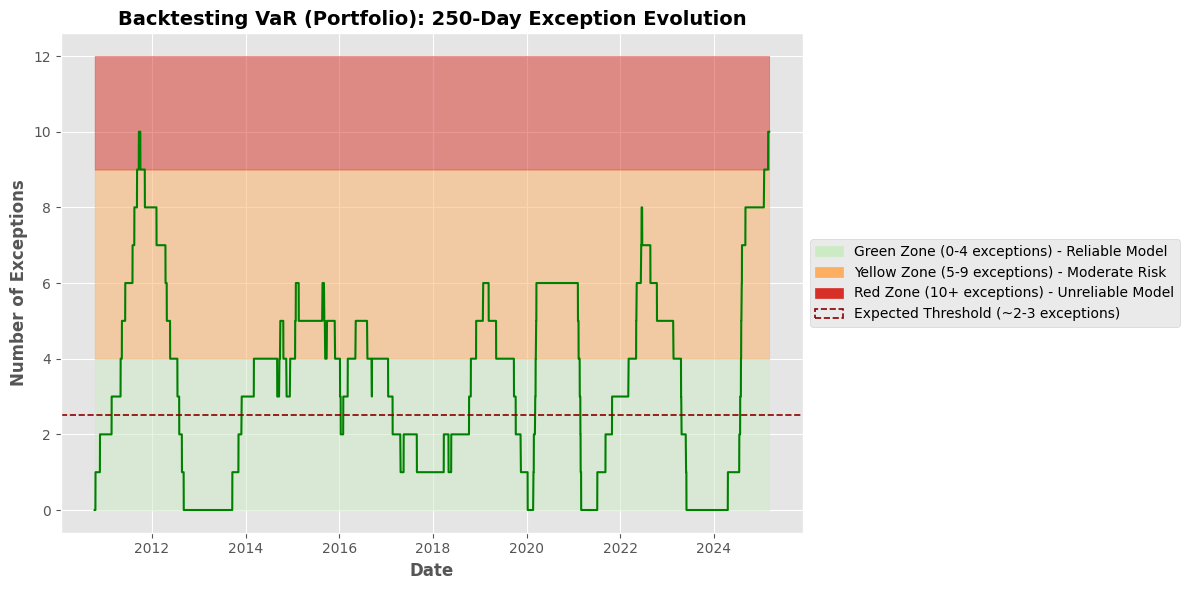

In [ ]:
# Define risk thresholds for exceptions
green_zone_threshold = 4  # Reliable model
yellow_zone_threshold = 9  # Moderate risk
red_zone_threshold = 10  # Unreliable model

# Function for plotting with risk zones
def plot_var_exceptions(data, title, color):
    """
    Displays the number of VaR exceptions with risk zone coloring.

    :param data: DataFrame containing 'Exception_Count' and indexed by 'Date'
    :param title: Chart title
    :param color: Main curve color
    """
    plt.figure(figsize=(12, 6))

    # Plot the number of exceptions
    plt.plot(data.index, data['Exception_Count'], label="Number of exceptions (250 days)", color=color, linewidth=1.5)

    # Add color-coded risk zones
    plt.fill_between(data.index, 0, green_zone_threshold, color='#ccebc5', alpha=0.5)
    plt.fill_between(data.index, green_zone_threshold, yellow_zone_threshold, color='#fdae61', alpha=0.5)
    plt.fill_between(data.index, yellow_zone_threshold, max(data['Exception_Count'].max(), red_zone_threshold + 2),
                     color='#d73027', alpha=0.5)

    # Expected threshold line (VaR 99%)
    plt.axhline(y=window_size * (1 - confidence_level), color='darkred', linestyle='--', linewidth=1.2)

    # Academic-style customization
    plt.xlabel("Date", fontsize=12, fontweight='bold')
    plt.ylabel("Number of Exceptions", fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold')

    # Create patches for the legend
    legend_patches = [
        mpatches.Patch(color='#ccebc5', label="Green Zone (0-4 exceptions) - Reliable Model"),
        mpatches.Patch(color='#fdae61', label="Yellow Zone (5-9 exceptions) - Moderate Risk"),
        mpatches.Patch(color='#d73027', label="Red Zone (10+ exceptions) - Unreliable Model"),
        mpatches.Patch(facecolor='none', edgecolor='darkred', linestyle='--', linewidth=1.2,
                       label="Expected Threshold (~2-3 exceptions)")
    ]

    # Position legend on the right for better readability
    plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, frameon=True)

    # Adjust layout for better visibility
    plt.tight_layout()
    plt.show()


# Plot exceptions for CAC 40
plot_var_exceptions(cac40, "Backtesting VaR (CAC 40): 250-Day Exception Evolution", "blue")

# Plot exceptions for Portfolio
plot_var_exceptions(portfolio_performance, "Backtesting VaR (Portfolio): 250-Day Exception Evolution", "green")


**5.1.2. Kupiec Test with Monte Carlo Var**

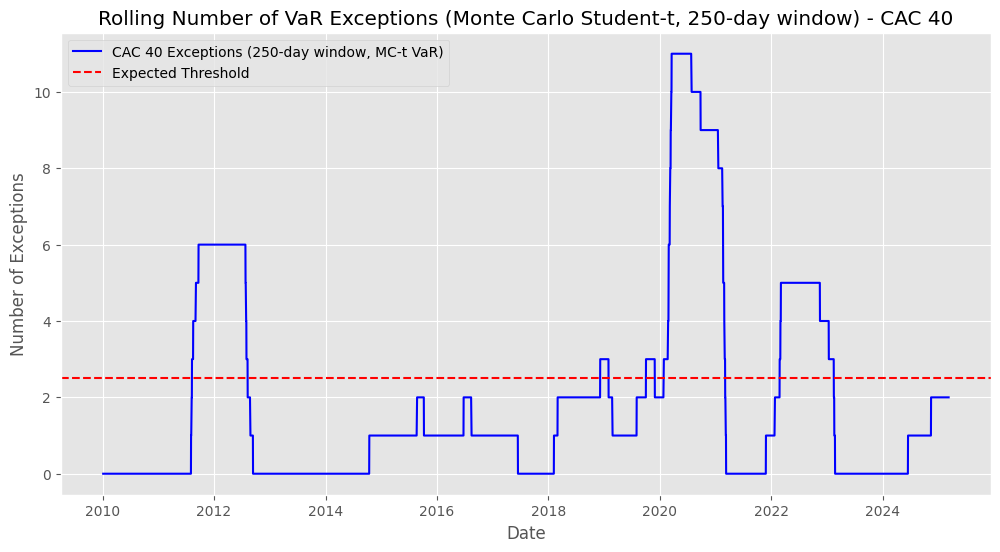

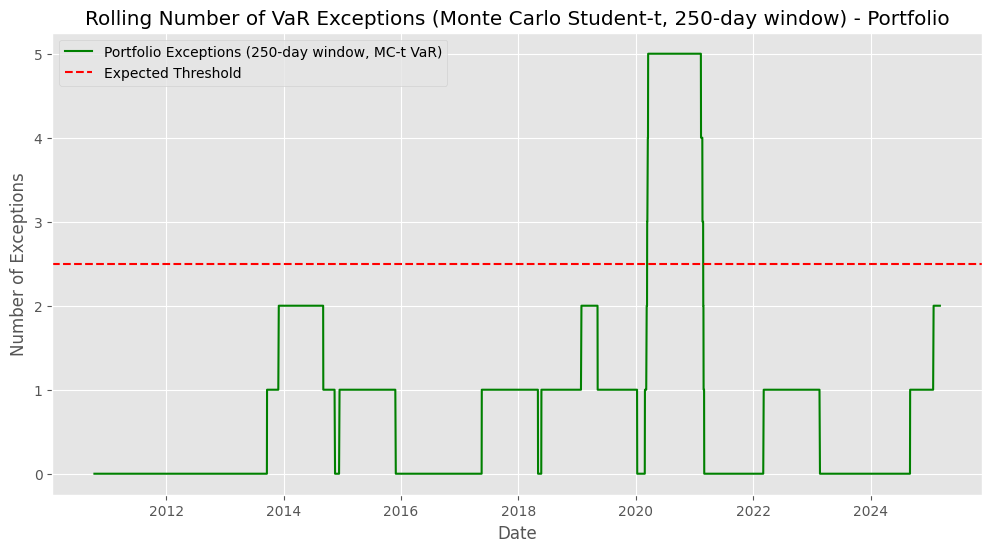


--- CAC 40 Monte Carlo Student-t VaR Kupiec Test Results ---
            VaR_MC_t_99  Exception_Count_MC_t  Kupiec_p_value_MC_t
Date                                                              
2025-02-24    -0.027954                   2.0             0.741933
2025-02-25    -0.028417                   2.0             0.741933
2025-02-26    -0.028211                   2.0             0.741933
2025-02-27    -0.027773                   2.0             0.741933
2025-02-28    -0.027621                   2.0             0.741933
2025-03-03    -0.028896                   2.0             0.741933
2025-03-04    -0.029563                   2.0             0.741933
2025-03-05    -0.029161                   2.0             0.741933
2025-03-06    -0.028712                   2.0             0.741933
2025-03-07    -0.028801                   2.0             0.741933

--- Portfolio Monte Carlo Student-t VaR Kupiec Test Results ---
            VaR_MC_t_99  Exception_Count_MC_t  Kupiec_p_value_MC_t
Da

In [ ]:
# Ensure data is numeric and cleaned
cac40['DLCAC40'] = pd.to_numeric(cac40['DLCAC40'], errors='coerce').dropna()
portfolio_performance['Return'] = pd.to_numeric(portfolio_performance['Return'], errors='coerce').dropna()

# Define parameters
confidence_level = 0.99  # 99% VaR
window_size = 250  # 250-day rolling window

# Ensure Date Columns Exist and Convert to Datetime
if 'Date' in cac40.columns:
    cac40['Date'] = pd.to_datetime(cac40['Date'])
    cac40.set_index('Date', inplace=True)

if 'Date' in portfolio_performance.columns:
    portfolio_performance['Date'] = pd.to_datetime(portfolio_performance['Date'])
    portfolio_performance.set_index('Date', inplace=True)

# Ensure Monte Carlo Student-t VaR columns exist
mc_t_var_columns = ['VaR_MC_t_99']
for col in mc_t_var_columns:
    if col not in cac40.columns or col not in portfolio_performance.columns:
        raise KeyError(f"Missing Monte Carlo Student-t VaR column: {col}")

# Identify exceptions (when returns fall below Monte Carlo Student-t VaR)
cac40['Exception_MC_t'] = (cac40['DLCAC40'] < cac40['VaR_MC_t_99']).astype(int)
portfolio_performance['Exception_MC_t'] = (portfolio_performance['Return'] < portfolio_performance['VaR_MC_t_99']).astype(int)

# Count exceptions over a rolling 250-day window
cac40['Exception_Count_MC_t'] = cac40['Exception_MC_t'].rolling(window=window_size, min_periods=1).sum()
portfolio_performance['Exception_Count_MC_t'] = portfolio_performance['Exception_MC_t'].rolling(window=window_size, min_periods=1).sum()

# Kupiec Test Function
def kupiec_test(num_exceptions, total_obs, var_level):
    """
    Kupiec likelihood ratio test for validating the exception frequency of VaR.

    Parameters:
    - num_exceptions: observed number of exceptions
    - total_obs: total number of observations (e.g., 250 days)
    - var_level: confidence level of VaR (e.g., 0.99)

    Returns:
    - p-value from the chi-squared test
    """
    if num_exceptions == 0 or num_exceptions == total_obs:  # Avoid log(0) issue
        return 1.0

    p_hat = num_exceptions / total_obs  # Observed exception frequency
    p_expected = 1 - var_level  # Expected exception frequency

    log_likelihood_ratio = -2 * np.log(
        ((1 - p_expected) ** (total_obs - num_exceptions) * (p_expected ** num_exceptions)) /
        ((1 - p_hat) ** (total_obs - num_exceptions) * (p_hat ** num_exceptions))
    )

    return 1 - stats.chi2.cdf(log_likelihood_ratio, df=1)  # Chi-squared test with 1 degree of freedom

# Apply Kupiec Test Efficiently for Monte Carlo Student-t VaR
cac40['Kupiec_p_value_MC_t'] = np.nan
portfolio_performance['Kupiec_p_value_MC_t'] = np.nan

valid_indices_cac40 = cac40.index[window_size-1:]  # Avoid unnecessary computation
valid_indices_portfolio = portfolio_performance.index[window_size-1:]

for i in valid_indices_cac40:
    start_index = i - pd.DateOffset(days=window_size-1)  # Corrected subtraction
    num_exceptions = cac40.loc[start_index:i, 'Exception_Count_MC_t'].iloc[-1]
    cac40.loc[i, 'Kupiec_p_value_MC_t'] = kupiec_test(num_exceptions, window_size, confidence_level)

for i in valid_indices_portfolio:
    start_index = i - pd.DateOffset(days=window_size-1)  # Corrected subtraction
    num_exceptions = portfolio_performance.loc[start_index:i, 'Exception_Count_MC_t'].iloc[-1]
    portfolio_performance.loc[i, 'Kupiec_p_value_MC_t'] = kupiec_test(num_exceptions, window_size, confidence_level)

# Plot Rolling Exception Count for CAC 40 Monte Carlo Student-t VaR
plt.figure(figsize=(12, 6))
plt.plot(cac40.index, cac40['Exception_Count_MC_t'], label="CAC 40 Exceptions (250-day window, MC-t VaR)", color='blue')
plt.axhline(y=window_size * (1 - confidence_level), color='red', linestyle='--', label="Expected Threshold")
plt.xlabel("Date")
plt.ylabel("Number of Exceptions")
plt.title("Rolling Number of VaR Exceptions (Monte Carlo Student-t, 250-day window) - CAC 40")
plt.legend()
plt.grid(True)
plt.show()

# Plot Rolling Exception Count for Portfolio Monte Carlo Student-t VaR
plt.figure(figsize=(12, 6))
plt.plot(portfolio_performance.index, portfolio_performance['Exception_Count_MC_t'], label="Portfolio Exceptions (250-day window, MC-t VaR)", color='green')
plt.axhline(y=window_size * (1 - confidence_level), color='red', linestyle='--', label="Expected Threshold")
plt.xlabel("Date")
plt.ylabel("Number of Exceptions")
plt.title("Rolling Number of VaR Exceptions (Monte Carlo Student-t, 250-day window) - Portfolio")
plt.legend()
plt.grid(True)
plt.show()

# Display final results for Monte Carlo Student-t VaR
print("\n--- CAC 40 Monte Carlo Student-t VaR Kupiec Test Results ---")
print(cac40[['VaR_MC_t_99', 'Exception_Count_MC_t', 'Kupiec_p_value_MC_t']].dropna().tail(10))  # Show last 10 results

print("\n--- Portfolio Monte Carlo Student-t VaR Kupiec Test Results ---")
print(portfolio_performance[['VaR_MC_t_99', 'Exception_Count_MC_t', 'Kupiec_p_value_MC_t']].dropna().tail(10))  # Show last 10 results)


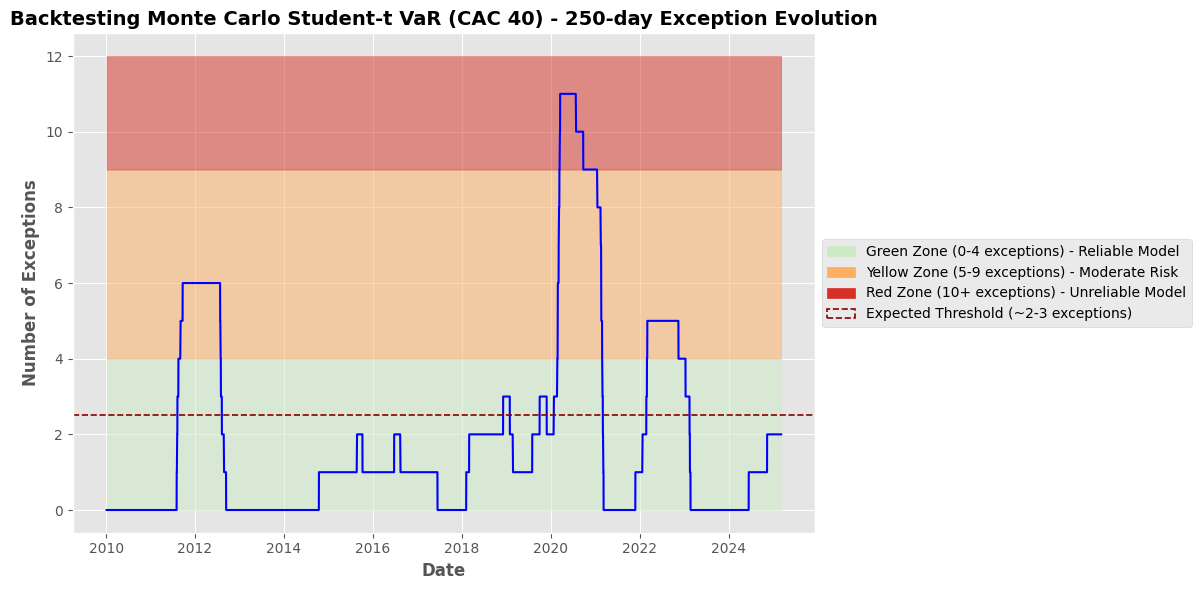

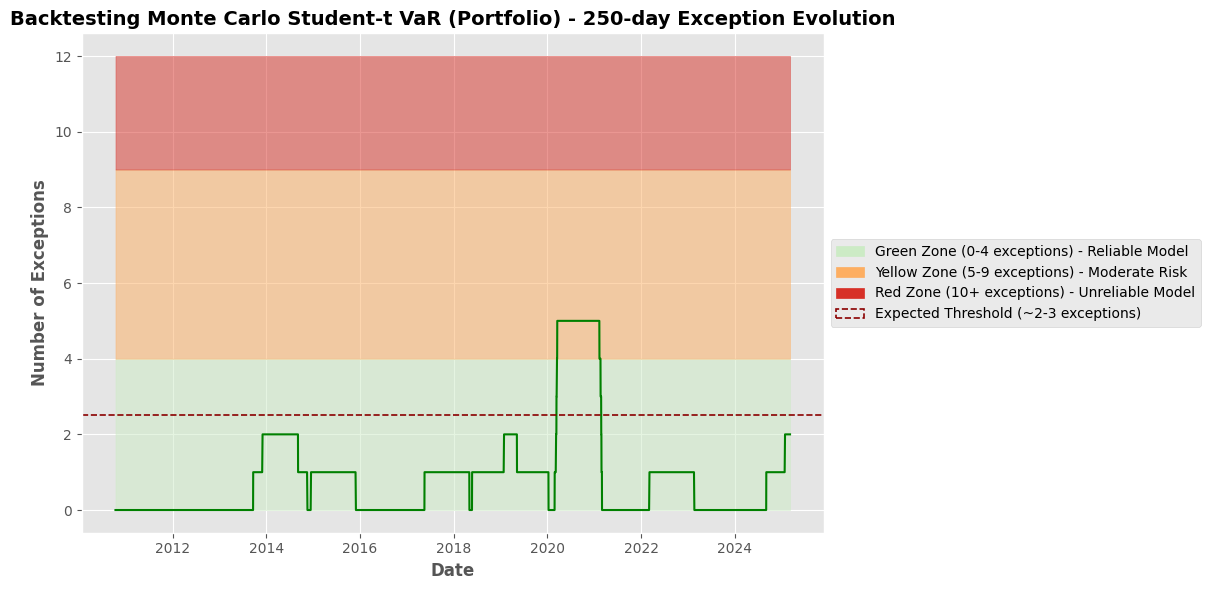

In [ ]:
# Define risk thresholds for exceptions
green_zone_threshold = 4  # Reliable model
yellow_zone_threshold = 9  # Moderate risk
red_zone_threshold = 10  # Unreliable model

# Plotting function with color-coded zones
def plot_var_exceptions(data, title, color):
    """
    Displays the number of Monte Carlo Student-t VaR exceptions with risk color zones.

    :param data: DataFrame containing 'Exception_Count_MC_t' and indexed by 'Date'
    :param title: Graph title
    :param color: Main line color
    """
    plt.figure(figsize=(12, 6))

    # Plot exception count
    plt.plot(data.index, data['Exception_Count_MC_t'], label="Exceptions (250-day window)", color=color, linewidth=1.5)

    # Add color zones
    plt.fill_between(data.index, 0, green_zone_threshold, color='#ccebc5', alpha=0.5)
    plt.fill_between(data.index, green_zone_threshold, yellow_zone_threshold, color='#fdae61', alpha=0.5)
    plt.fill_between(data.index, yellow_zone_threshold, max(data['Exception_Count_MC_t'].max(), red_zone_threshold + 2),
                     color='#d73027', alpha=0.5)

    # Expected threshold line (approx. 2-3 exceptions for 99% VaR)
    plt.axhline(y=window_size * (1 - confidence_level), color='darkred', linestyle='--', linewidth=1.2)

    # Academic-style customization
    plt.xlabel("Date", fontsize=12, fontweight='bold')
    plt.ylabel("Number of Exceptions", fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold')

    # Create patches for legend
    legend_patches = [
        mpatches.Patch(color='#ccebc5', label="Green Zone (0-4 exceptions) - Reliable Model"),
        mpatches.Patch(color='#fdae61', label="Yellow Zone (5-9 exceptions) - Moderate Risk"),
        mpatches.Patch(color='#d73027', label="Red Zone (10+ exceptions) - Unreliable Model"),
        mpatches.Patch(facecolor='none', edgecolor='darkred', linestyle='--', linewidth=1.2,
                       label="Expected Threshold (~2-3 exceptions)")
    ]

    # Position legend on the right for better readability
    plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, frameon=True)

    # Adjust layout for better visibility
    plt.tight_layout()
    plt.show()


# Plot exceptions for CAC 40 (Monte Carlo Student-t VaR)
plot_var_exceptions(cac40, "Backtesting Monte Carlo Student-t VaR (CAC 40) - 250-day Exception Evolution", "blue")

# Plot exceptions for Portfolio (Monte Carlo Student-t VaR)
plot_var_exceptions(portfolio_performance, "Backtesting Monte Carlo Student-t VaR (Portfolio) - 250-day Exception Evolution", "green")


## **6. T-Student Monte Carlo Var reaction to Macro Chocs**

 ### Macro Variables :


*   Unemployment_Rate
*   Consumer_Sentiment
*   Financial_Conditions
* Corporate_Bond_Spread
*   Crude_Oil_Price



In [ ]:
!pip install fredapi

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from fredapi import Fred
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Retrieve Macroeconomic Data from FRED
start_date = '2010-01-01'
end_date = '2024-12-01'

# FRED API Key
API_KEY = 'f174cfc44bce7bf06b8b02addd38e6b4'
fred = Fred(api_key=API_KEY)

# Define macroeconomic indicators (less correlated, more relevant)
macro_tickers = {
    "Unemployment_Rate": "UNRATE",  # Monthly - Labor market conditions
    "Consumer_Sentiment": "UMCSENT",  # Monthly - Confidence in economy
    "Financial_Conditions": "NFCI",  # Weekly - Liquidity stress index
    "Corporate_Bond_Spread": "BAMLC0A4CBBBEY",  # Daily - Credit risk proxy
    "Crude_Oil_Price": "DCOILWTICO"  # Daily - Commodity market indicator
}

# Download macroeconomic data from FRED
macro_data = {}
for name, ticker in macro_tickers.items():
    try:
        macro_data[name] = fred.get_series(ticker, start_date, end_date)
        print(f"Successfully downloaded {name}")
    except Exception as e:
        print(f"Failed to download {name}: {e}")

# Convert to DataFrame
macro_df = pd.DataFrame(macro_data)

# Convert index to datetime
macro_df.index = pd.to_datetime(macro_df.index)

# Step 2: Interpolate Missing Values for Non-Daily Data
macro_df = macro_df.ffill().interpolate(method='time')  # Forward-fill and interpolate

# Step 3: Generate a Full Daily Date Range
all_dates = pd.date_range(start=macro_df.index.min(), end=macro_df.index.max(), freq='D')

# Reindex the DataFrame to include all dates and interpolate
macro_df = macro_df.reindex(all_dates).interpolate(method='time')

# Step 4: Ensure Correct Indexing for Monte Carlo VaR Data
# Convert date columns to datetime and set as index
if 'Date' in cac40.columns:
    cac40['Date'] = pd.to_datetime(cac40['Date'])
    cac40.set_index('Date', inplace=True)

if 'Date' in portfolio_performance.columns:
    portfolio_performance['Date'] = pd.to_datetime(portfolio_performance['Date'])
    portfolio_performance.set_index('Date', inplace=True)

# Ensure Monte Carlo Student-t VaR column exists
mc_t_var_columns = ['VaR_MC_t_99']
for col in mc_t_var_columns:
    if col not in cac40.columns or col not in portfolio_performance.columns:
        raise KeyError(f"Missing Monte Carlo Student-t VaR column: {col}")

# Step 5: **Remove Duplicate Macro Variables Before Merge**
overlapping_cols = list(set(macro_df.columns) & set(cac40.columns))
if overlapping_cols:
    print(f"Dropping duplicate columns before merge: {overlapping_cols}")
    cac40.drop(columns=overlapping_cols, inplace=True)
    portfolio_performance.drop(columns=overlapping_cols, inplace=True)

# Step 6: Merge Macro Data with Monte Carlo VaR Data
# Merge datasets using INNER JOIN to keep only rows where VaR data exists
cac40 = cac40.merge(macro_df, left_index=True, right_index=True, how="inner")
portfolio_performance = portfolio_performance.merge(macro_df, left_index=True, right_index=True, how="inner")

# Remove any remaining missing values to ensure full data availability
cac40.dropna(subset=['VaR_MC_t_99'], inplace=True)
portfolio_performance.dropna(subset=['VaR_MC_t_99'], inplace=True)

print("Successfully merged macroeconomic data with CAC 40 and Portfolio VaR.")

# Step 7: Identify Monte Carlo VaR Exceptions
window_size = 250  # 250-day rolling window

cac40['Exception_MC_t'] = (cac40['DLCAC40'] < cac40['VaR_MC_t_99']).astype(int)
portfolio_performance['Exception_MC_t'] = (portfolio_performance['Return'] < portfolio_performance['VaR_MC_t_99']).astype(int)

# Count exceptions over a rolling 250-day window
cac40['Exception_Count_MC_t'] = cac40['Exception_MC_t'].rolling(window=window_size, min_periods=1).sum()
portfolio_performance['Exception_Count_MC_t'] = portfolio_performance['Exception_MC_t'].rolling(window=window_size, min_periods=1).sum()

print("Successfully calculated Monte Carlo VaR exceptions.")

# Step 8: Remove Duplicate Columns if Any
cac40 = cac40.loc[:, ~cac40.columns.duplicated()]
portfolio_performance = portfolio_performance.loc[:, ~portfolio_performance.columns.duplicated()]

print("Final dataset is clean and ready for analysis.")



Successfully downloaded Unemployment_Rate
Successfully downloaded Consumer_Sentiment
Successfully downloaded Financial_Conditions
Successfully downloaded Corporate_Bond_Spread
Successfully downloaded Crude_Oil_Price
Dropping duplicate columns before merge: ['Corporate_Bond_Spread', 'Consumer_Sentiment', 'Unemployment_Rate', 'Crude_Oil_Price', 'Financial_Conditions']
Successfully merged macroeconomic data with CAC 40 and Portfolio VaR.
Successfully calculated Monte Carlo VaR exceptions.
Final dataset is clean and ready for analysis.


In [ ]:
# Step 8: Display Summary Statistics
display("\nCAC 40 Summary Statistics:")
display(cac40.describe())

display("\nPortfolio Summary Statistics:")
display(portfolio_performance.describe())


'\nCAC 40 Summary Statistics:'

,CAC40,LCAC40,DLCAC40,Cumulative_Return,VaR_Histo_95,VaR_Histo_99,VaR_param_t_95,VaR_param_t_99,CVaR_Histo_95,CVaR_Histo_99,...,Financial_Conditions_var,Diff_VaR_MC_t_95,Diff_VaR_MC_t_99,VaR_MC_t_95,VaR_MC_t_99,Unemployment_Rate,Consumer_Sentiment,Financial_Conditions,Corporate_Bond_Spread,Crude_Oil_Price
count,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,...,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000
mean,5341.675963,8.555565,0.000269,1.091075,-0.019152,-0.031156,-0.019116,-0.027205,-0.027253,-0.039350,...,-0.483754,0.000006,0.000011,-0.023374,-0.039162,5.272856,82.423551,-0.483754,3.961244,69.797947
std,1255.673656,0.236602,0.011731,0.188113,0.007011,0.012214,0.006570,0.009191,0.010685,0.018560,...,0.187789,0.000641,0.001639,0.007963,0.013077,1.887602,12.818941,0.187789,1.013941,21.837829
min,2950.469971,7.989720,-0.130983,0.679141,-0.036055,-0.060198,-0.034684,-0.049000,-0.055013,-0.093270,...,-0.800440,-0.005977,-0.010856,-0.043865,-0.074045,3.400000,50.000000,-0.800440,2.050000,-36.980000
25%,4396.065063,8.388465,-0.005170,0.952939,-0.022662,-0.035900,-0.023150,-0.032858,-0.032716,-0.045187,...,-0.608080,-0.000365,-0.000944,-0.028247,-0.047271,3.800000,72.500000,-0.608080,3.390000,51.537500
50%,5167.264893,8.550099,0.000688,1.089776,-0.016168,-0.028268,-0.016972,-0.024335,-0.023588,-0.033012,...,-0.522890,0.000009,0.000020,-0.020862,-0.035306,4.700000,82.500000,-0.522890,3.770000,69.190000
75%,6285.697632,8.746032,0.006212,1.226114,-0.014179,-0.022483,-0.013972,-0.019925,-0.019844,-0.027356,...,-0.374330,0.000371,0.000979,-0.017088,-0.028682,6.200000,93.800000,-0.374330,4.430000,87.897500
max,8239.990234,9.016754,0.080561,1.533530,-0.009286,-0.015612,-0.010135,-0.014712,-0.012714,-0.017154,...,0.494970,0.004968,0.008922,-0.012315,-0.019642,14.800000,101.400000,0.494970,6.720000,123.640000


'\nPortfolio Summary Statistics:'

,Return,VaR_Histo_95,VaR_Histo_99,VaR_param_t_95,VaR_param_t_99,CVaR_Histo_95,CVaR_Histo_99,CVaR_MC_95,CVaR_MC_99,VaR_99,...,Financial_Conditions_var,Diff_VaR_MC_t_95,Diff_VaR_MC_t_99,VaR_MC_t_95,VaR_MC_t_99,Unemployment_Rate,Consumer_Sentiment,Financial_Conditions,Corporate_Bond_Spread,Crude_Oil_Price
count,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,...,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000
mean,0.000769,-0.036775,-0.056992,-0.037911,-0.054077,-0.050088,-0.068750,-0.047529,-0.061619,-0.056947,...,-0.494614,0.000003,0.000005,-0.046442,-0.077875,5.103576,82.909818,-0.494614,3.956531,68.160474
std,0.024127,0.009536,0.013800,0.010349,0.014442,0.011414,0.018225,0.012793,0.016388,0.013830,...,0.187157,0.001227,0.003173,0.012536,0.020504,1.811280,13.042293,0.187157,1.039086,21.400347
min,-0.160366,-0.060422,-0.083734,-0.068128,-0.096353,-0.074743,-0.113602,-0.086108,-0.112516,-0.082585,...,-0.800440,-0.006654,-0.017556,-0.085266,-0.142929,3.400000,50.000000,-0.800440,2.050000,-36.980000
25%,-0.012608,-0.041994,-0.067750,-0.043621,-0.062122,-0.057918,-0.077940,-0.054611,-0.070887,-0.067797,...,-0.620760,-0.000768,-0.001946,-0.053347,-0.088838,3.800000,72.300000,-0.620760,3.360000,50.625000
50%,0.000252,-0.036149,-0.056569,-0.034969,-0.049745,-0.048016,-0.069164,-0.043780,-0.056723,-0.056327,...,-0.529680,0.000005,-0.000018,-0.042896,-0.071544,4.400000,84.100000,-0.529680,3.740000,66.995000
75%,0.014265,-0.029355,-0.045766,-0.030376,-0.043642,-0.041420,-0.056419,-0.038255,-0.049675,-0.045736,...,-0.390630,0.000751,0.002046,-0.037405,-0.063081,5.900000,95.100000,-0.390630,4.460000,84.550000
max,0.121051,-0.020100,-0.032380,-0.022621,-0.032688,-0.028423,-0.036101,-0.028287,-0.037139,-0.032389,...,0.494970,0.006928,0.012228,-0.027565,-0.045729,14.800000,101.400000,0.494970,6.720000,123.640000


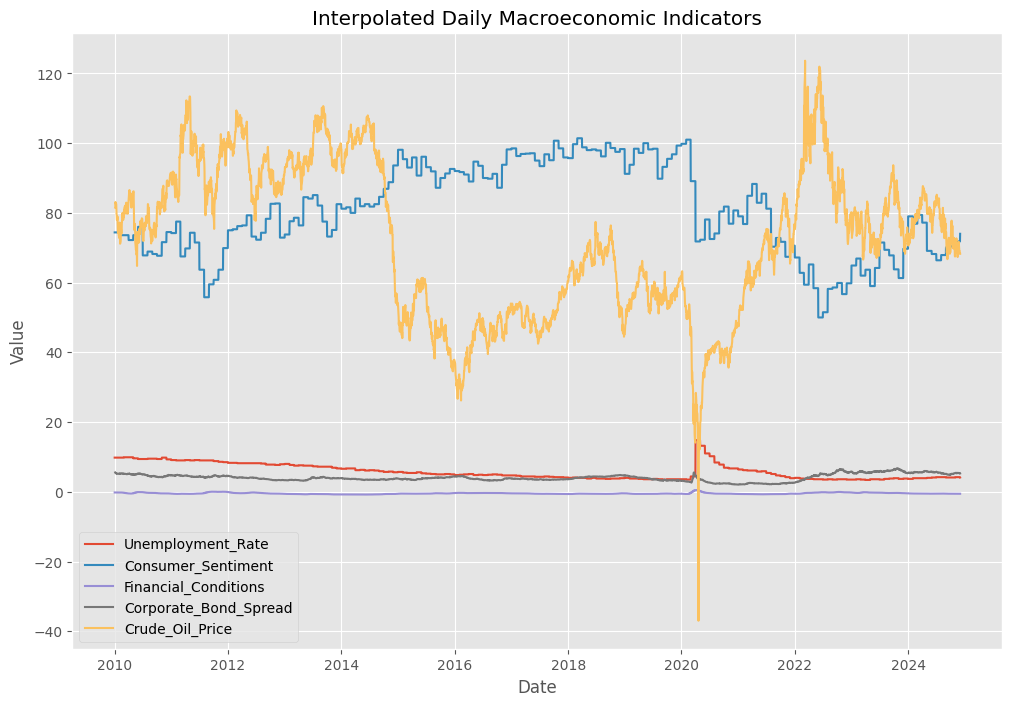

In [ ]:
# Step 9: Plot Macroeconomic Variables
plt.figure(figsize=(12, 8))
for column in macro_df.columns:
    plt.plot(macro_df.index, macro_df[column], label=column)

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Interpolated Daily Macroeconomic Indicators")
plt.legend()
plt.grid(True)
plt.show()


Log Transformation

In [ ]:
macro_df["Log_Crude_Oil_Price"] = np.log(macro_df["Crude_Oil_Price"])
macro_df.drop(columns=["Crude_Oil_Price"], inplace=True)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ADF Test

In [ ]:
# List of macroeconomic variables to test
macro_variables = ["Unemployment_Rate", "Consumer_Sentiment", "Financial_Conditions",
                   "Corporate_Bond_Spread", "Log_Crude_Oil_Price"]  # Log-transformed

# List of Monte Carlo VaR estimates to test
var_variables = ["VaR_MC_t_95", "VaR_MC_t_99"]

# Dictionary to track p-values
non_stationary_vars = []  # List to store non-stationary variables

# Perform ADF test on macroeconomic variables
print("\nInitial ADF Test Results for Macroeconomic Variables:")
for col in macro_variables:
    p_value = adf_test(macro_df[col], col)
    if p_value >= 0.05:  # If not stationary, mark for differencing
        non_stationary_vars.append(col)

# Perform ADF test on Monte Carlo VaR estimates
print("\nInitial ADF Test Results for Monte Carlo VaR Estimates (CAC 40):")
for col in var_variables:
    p_value = adf_test(cac40[col], f"CAC40_{col}")
    if p_value >= 0.05:
        non_stationary_vars.append(f"CAC40_{col}")

print("\nInitial ADF Test Results for Monte Carlo VaR Estimates (Portfolio):")
for col in var_variables:
    p_value = adf_test(portfolio_performance[col], f"Portfolio_{col}")
    if p_value >= 0.05:
        non_stationary_vars.append(f"Portfolio_{col}")



Initial ADF Test Results for Macroeconomic Variables:

ADF Test for Unemployment_Rate:
ADF Statistic: -2.8540, p-value: 0.0510
Not Stationary

ADF Test for Consumer_Sentiment:
ADF Statistic: -2.1494, p-value: 0.2251
Not Stationary

ADF Test for Financial_Conditions:
ADF Statistic: -4.6032, p-value: 0.0001
Stationary

ADF Test for Corporate_Bond_Spread:
ADF Statistic: -2.0389, p-value: 0.2698
Not Stationary

ADF Test for Log_Crude_Oil_Price:
ADF Statistic: -2.7568, p-value: 0.0647
Not Stationary

Initial ADF Test Results for Monte Carlo VaR Estimates (CAC 40):

ADF Test for CAC40_VaR_MC_t_95:
ADF Statistic: -2.1357, p-value: 0.2304
Not Stationary

ADF Test for CAC40_VaR_MC_t_99:
ADF Statistic: -2.0426, p-value: 0.2682
Not Stationary

Initial ADF Test Results for Monte Carlo VaR Estimates (Portfolio):

ADF Test for Portfolio_VaR_MC_t_95:
ADF Statistic: -1.9843, p-value: 0.2935
Not Stationary

ADF Test for Portfolio_VaR_MC_t_99:
ADF Statistic: -1.8519, p-value: 0.3550
Not Stationary


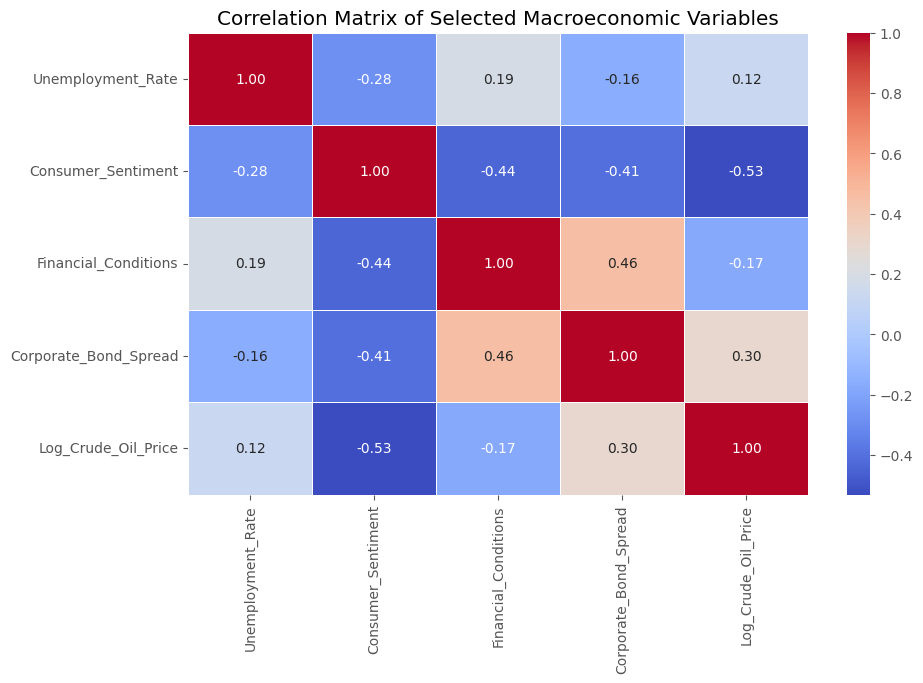

In [ ]:
# Step 10: Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(macro_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Selected Macroeconomic Variables")
plt.show()

First Diff

In [ ]:
print("\nApplying First Differencing to Non-Stationary Variables...")

# Apply first differencing to macro variables
for col in macro_variables:
    if col in non_stationary_vars:
        macro_df[f"Diff_{col}"] = macro_df[col].diff()

# Apply first differencing to Monte Carlo VaR estimates
for col in var_variables:
    if f"CAC40_{col}" in non_stationary_vars:
        cac40[f"Diff_{col}"] = cac40[col].diff()
    if f"Portfolio_{col}" in non_stationary_vars:
        portfolio_performance[f"Diff_{col}"] = portfolio_performance[col].diff()

# Drop original non-stationary columns
macro_df.drop(columns=[col for col in macro_variables if col in non_stationary_vars], inplace=True)
cac40.drop(columns=[col for col in var_variables if f"CAC40_{col}" in non_stationary_vars], inplace=True)
portfolio_performance.drop(columns=[col for col in var_variables if f"Portfolio_{col}" in non_stationary_vars], inplace=True)

# Drop NA values created by differencing
macro_df.dropna(inplace=True)
cac40.dropna(inplace=True)
portfolio_performance.dropna(inplace=True)


Applying First Differencing to Non-Stationary Variables...


In [ ]:
print("\nADF Test After Differencing:")

# Perform ADF test again
for col in macro_df.columns:
    adf_test(macro_df[col], col)

for col in cac40.columns:
    if "Diff_" in col:
        adf_test(cac40[col], col)

for col in portfolio_performance.columns:
    if "Diff_" in col:
        adf_test(portfolio_performance[col], col)

print("\nAll non-stationary variables have been differenced and re-tested.")



ADF Test After Differencing:

ADF Test for Financial_Conditions:
ADF Statistic: -3.7826, p-value: 0.0031
Stationary

ADF Test for Diff_Unemployment_Rate:
ADF Statistic: -12.7041, p-value: 0.0000
Stationary

ADF Test for Diff_Consumer_Sentiment:
ADF Statistic: -73.5571, p-value: 0.0000
Stationary

ADF Test for Diff_Corporate_Bond_Spread:
ADF Statistic: -16.6981, p-value: 0.0000
Stationary

ADF Test for Diff_Log_Crude_Oil_Price:
ADF Statistic: -13.9956, p-value: 0.0000
Stationary

ADF Test for Diff_VaR_MC_t_95:
ADF Statistic: -10.3551, p-value: 0.0000
Stationary

ADF Test for Diff_VaR_MC_t_99:
ADF Statistic: -10.5929, p-value: 0.0000
Stationary

ADF Test for Diff_Unemployment_Rate:
ADF Statistic: -11.0912, p-value: 0.0000
Stationary

ADF Test for Diff_Consumer_Sentiment:
ADF Statistic: -52.9538, p-value: 0.0000
Stationary

ADF Test for Diff_Corporate_Bond_Spread:
ADF Statistic: -9.7632, p-value: 0.0000
Stationary

ADF Test for Diff_Crude_Oil_Price:
ADF Statistic: -10.5437, p-value: 0.00

## **6.2 OLS Regression**

Simple OLS Regression

In [ ]:
# Define independent variables (macro variables)
macro_vars = [
    "Diff_Unemployment_Rate",
    "Diff_Consumer_Sentiment",
    "Diff_Corporate_Bond_Spread",
    "Diff_Crude_Oil_Price",
    "Financial_Conditions"
]

# Define dependent variables (Monte Carlo VaR)
var_targets = ["Diff_VaR_MC_t_95", "Diff_VaR_MC_t_99"]

# Step 1: Prepare the dataset (drop missing values for OLS regression)
ols_data = cac40[var_targets + macro_vars].dropna()

# Step 2: Run OLS Regression for each VaR target
print("\n### OLS Regression Results ###")
for var in var_targets:
    X = ols_data[macro_vars]  # Independent variables
    y = ols_data[var]  # Dependent variable (VaR)

    # Add constant term for intercept
    X = sm.add_constant(X)

    # Fit OLS Model
    model = sm.OLS(y, X).fit()

    # Print summary results
    print(f"\nRegression for {var}:")
    print(model.summary())



### OLS Regression Results ###

Regression for Diff_VaR_MC_t_95:
                            OLS Regression Results                            
Dep. Variable:       Diff_VaR_MC_t_95   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.537
Date:                Sun, 09 Mar 2025   Prob (F-statistic):             0.0267
Time:                        13:33:09   Log-Likelihood:                 16663.
No. Observations:                2806   AIC:                        -3.331e+04
Df Residuals:                    2800   BIC:                        -3.328e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

Lagged Reg

In [ ]:
# Add lagged macroeconomic variables
for lag in [1, 5, 10]:  # 1-day, 5-day, and 10-day lags
    for col in macro_vars:
        cac40[f"{col}_lag{lag}"] = cac40[col].shift(lag)

# Prepare new dataset
lagged_vars = [f"{col}_lag{lag}" for col in macro_vars for lag in [1, 5, 10]]
ols_data_lagged = cac40[var_targets + lagged_vars].dropna()

# Run OLS with lagged variables
print("\n### OLS Regression with Lagged Macroeconomic Variables ###")
for var in var_targets:
    X = ols_data_lagged[lagged_vars]  # Independent variables
    y = ols_data_lagged[var]  # Dependent variable (VaR)

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    print(f"\nRegression for {var} with lags:")
    print(model.summary())



### OLS Regression with Lagged Macroeconomic Variables ###

Regression for Diff_VaR_MC_t_95 with lags:
                            OLS Regression Results                            
Dep. Variable:       Diff_VaR_MC_t_95   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.746
Date:                Sun, 09 Mar 2025   Prob (F-statistic):           0.000322
Time:                        13:35:16   Log-Likelihood:                 16616.
No. Observations:                2796   AIC:                        -3.320e+04
Df Residuals:                    2780   BIC:                        -3.311e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-----

Rolling OLS R2

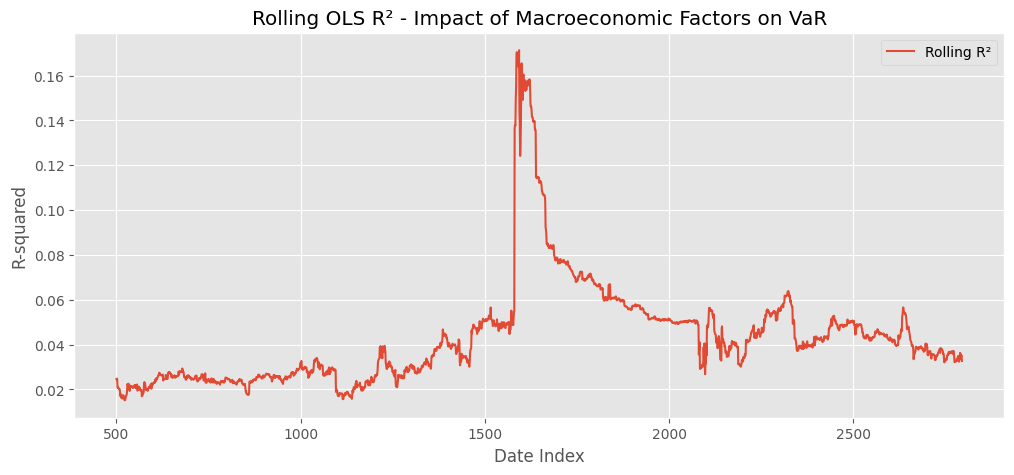

In [ ]:
import statsmodels.api as sm

# Define rolling window size
rolling_window = 500

# Prepare results storage
rolling_results = []

# Iterate through time series with rolling window
for i in range(rolling_window, len(ols_data_lagged)):
    # Select rolling window
    rolling_sample = ols_data_lagged.iloc[i - rolling_window : i]

    # Define independent & dependent variables
    X = rolling_sample[lagged_vars]  # Macro variables
    y = rolling_sample['Diff_VaR_MC_t_99']  # 99% Monte Carlo VaR

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    # Store R-squared for analysis
    rolling_results.append(model.rsquared)

# Plot Rolling R-Squared
plt.figure(figsize=(12, 5))
plt.plot(range(rolling_window, len(ols_data_lagged)), rolling_results, label="Rolling R²")
plt.xlabel("Date Index")
plt.ylabel("R-squared")
plt.title("Rolling OLS R² - Impact of Macroeconomic Factors on VaR")
plt.legend()
plt.grid(True)
plt.show()
